# Outages modeling of Generators for Adequacy Assesment
In this notebook we showcase some possible example of possible models for outages highlightening advantages and disadvantages of each. The dataset used can be found on https://transparency.entsoe.eu/.

# TODOS
- Data Analysis on State Time an Capacity of the state are they correlated? ---> Not indipendent
- Fix maintenance check
- Change days to hours in plot

In [2]:
#imports 

import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import expon
from scipy.optimize import curve_fit
from astropy.visualization import hist
#for fitting:
from scipy.stats import expon
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
#for plotting Markov Chain graph
import networkx as nx
import matplotlib.pyplot as plt


#helper functions

def import_df(path, cols = ['StartTS', 'EndTS', 'TimeZone', 'Status', 'Type', 'AreaCode',
       'AreaTypeCode', 'AreaName', 'MapCode', 'PowerResourceEIC', 'UnitName',
       'ProductionType', 'InstalledCapacity', 'AvailableCapacity',
       'Reason']):
    """
    imports and preprocess data_frame
    path: string containing path of csv file containing table
    cols: list of column names to select in df
    returns: non redundat dataframe with only failures
    """
    
    df = pd.read_csv(path, sep = "\t", parse_dates = [0,1])
    df = df[cols] #selects only column
    df = df.drop_duplicates(subset = ["UnitName","StartTS"]) #deletes redundant rows
    #df = df[(df["Reason"] == "Failure")] # WHERE | (df["Reason"] == 'Foreseen Maintenance')
    #maybe can do df[df["Reason"] in reasons]?
    return df

def get_week(date):
    """
    input: date in date_time format
    output: what week of the year the date corresponds to
    """
    return date.week


def truncate(number, digits) -> float:
    # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
    nbDecimals = len(str(number).split('.')[1]) 
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

def markov_graph(transitions, seed = 42, digits = 4, title = ""):
    """
    input: transitions, a dictionary having as 
    keys: touples with 2 elements being the from state and from state
    values: the transition probability
    output: markov chain graph
    """
    G = nx.MultiDiGraph()

    for transition, probability in transitions.items():
        state_from, state_to = transition
        if probability != 0: 
        #if probability state_from to state_to is not 0 we add an edge to the graph
            G.add_edge(state_from, state_to, weight=truncate(probability, digits))

    #create positions of nodes: dictionary with coordinates
    pos = nx.spring_layout(G, seed) 

    # Increase the scale to avoid overlap
    pos = {k: [v[0] * 2, v[1] * 2] for k, v in pos.items()}

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black',
            connectionstyle='arc3,rad=0.1')

    # Annotate edges manually with adjusted positions to avoid overlap
    for edge, weight in labels.items():
        (x, y) = pos[edge[0]]
        text_x = 3/4*x + 1/4*pos[edge[1]][0]
        text_y = 3/4*y + 1/4*pos[edge[1]][1]
        #shift text to avoid overlap
        text_y += 0.2 if edge[0] == edge[1] else 0


        plt.text(text_x, text_y, f"{weight}", fontsize=8, color='blue', verticalalignment='center',
                 horizontalalignment='center')
    plt.title(title)
    plt.show()
    
    
def combine_overlaps(df):
    """
    this functions combines any time overlaps present in the dataframe for each generator
    so that for every time t there is at most one row describing the generator at time t.
    df: dataframe containing UnitName, StartTS, EndTS
    """

    # Step 1: Sort the DataFrame
    df.sort_values(by=["UnitName", "StartTS"], inplace=True)

    # Step 2 and 3: Combine overlapping intervals
    result = []
    current_interval = None
    n_rows = df.shape[0]
    perc = n_rows // 100

    for k, row in df.iterrows():
        if k % perc == 0:
            print(f"percentage of rows parsed = {k / n_rows *100:.2f}%")
        if current_interval is None:
             current_interval = row.copy()
        elif row["StartTS"] >= current_interval["EndTS"] or row["UnitName"] != current_interval["UnitName"]:
            # No overlap or new UnitID
            result.append(current_interval)
            current_interval = row.copy()
        else:
            # Overlapping intervals, update the EndTS
            current_interval["EndTS"] = row["StartTS"]

    result_df = pd.DataFrame(result)

    return result_df


def get_markov_probs(df, states_column):
    """
    input:
    df: dataframe having as columns: states_column, "ProductionType", "StartTS", "UpTime"
    states_column: string with name of column where the state of the generator is saved
    output: dictionary having as keys tuples with two states and the associated probability transition
    """
    states = list(df[states_column].unique())
    states.append("Running")
    transitions = []
    for x in states:
        for y in states:
            transitions.append((x,y))
            
    transitions_counter = dict(zip(transitions, [0]*len(transitions)))
    GenGroups = df.groupby("UnitName")
    previous_state = "Running"
    current_state = "Running"
    for unit_name, unit_df in GenGroups:
        unit_df = unit_df.sort_values(["StartTS"])
        #count transition occurante for unit
        for index, row in unit_df.iterrows():
            uptime = row["UpTime"]
            #get current state from row
            current_state = row[states_column]

            if pd.isna(uptime):
                #if uptime == "Nan" then it was the first recorded instance of the generator in the dataframe so before it was running.
                previous_state = "Running"
            elif uptime > 10 / (60 * 24): # and previous_state != "Running"
                #if the generator had some time between the previous row than the previous state was running
                #and we must add 1 to previousprevious state and running
                transitions_counter[(previous_state, "Running")] += 1
                previous_state = "Running"    

            transitions_counter[(previous_state, current_state)] += 1
            #the current state becomes the previous_state
            previous_state = current_state

    #get the transtions probabilities
    transitions_probs = transitions_counter
    counter_dict = dict(zip(states, [0]*len(states)))
    for state in states:
        for transition, counter in transitions_probs.items():
            if transition[0] == state:
                counter_dict[state] += counter 

    for transition, counter in transitions_probs.items():
        if counter_dict[transition[0]] != 0:
            #if transition[0] occurs at least one time
            transitions_probs[transition] = transitions_probs[transition] / counter_dict[transition[0]]
    return transitions_probs




# Trying out various density estimators

(array([5.20004199, 2.69002172, 1.19000961, 0.49000396, 0.24000194,
        0.10000081, 0.04000032, 0.03000024, 0.01000008, 0.01000008]),
 array([8.07577085e-06, 1.00007268e-01, 2.00006461e-01, 3.00005653e-01,
        4.00004845e-01, 5.00004038e-01, 6.00003230e-01, 7.00002423e-01,
        8.00001615e-01, 9.00000808e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

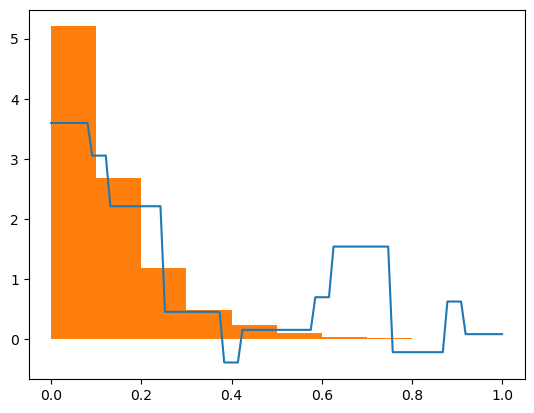

In [11]:
#Orthogonal Series Density Estimation:
#area in estimator is not 1?
def Phi(x,j):
    #Orthogonal functions family
    if j == 0:
        return 1
    else:
        return np.sqrt(2)*np.cos(np.pi*j*x)

def OrthogonalSeriesEstimator(X, Phi, J):
    """
    Calculates the estimators of the coefficients of the orthogonal series associated to the famili Phi_j
    up to J
    inputs:
    X: vector containing samples
    Phi: function in x and j
    J: cutoff integer
    returns: array a_0, ..., a_j
    todo: vectorify it
    """
    a = []
    n_samples = len(X)
    for j in range(0,J+1):
        Phi_k = np.vectorize(lambda x: Phi(x,j))
        a_vec = Phi_k(X)
        a.append(np.sum(a_vec)/ n_samples)
    
    return np.array(a)

def OrthogonalSeriesFun(x, Phi, a):
    Phix = np.vectorize(lambda j : Phi(x,j))
    J = len(a)
    return np.dot(a, Phix(np.arange(J)))

def Cutoff(X, Phi):
    #redo
    N = len(X)
    for j in range(1, N):
        Phi_j = lambda x: Phi(x,j)
        a_vec = Phi_k(X)
        a_hat = np.sum(a_vec) / N
        if 2 > j * (a_hat**2):
            return j

X = np.random.exponential(scale = 1, size=1000)
X = X / np.max(X)
a = OrthogonalSeriesEstimator(X, Phi, 3)
pdf_appr = lambda x : OrthogonalSeriesFun(x, Phi, a)

X1 = np.linspace(0,1,100)
Y1 = []
for i in range(100):
    y = pdf_appr(X1[i])
    Y1.append(y)
    
Y1 = np.array(Y1)
plt.plot(X1, Y1)
plt.hist(X, density = True)


In [13]:
#Dataframe example
#repository = "UnavailabilityOfGenerationUnits"
path = r'U:\ENTSO-E Transparency Platform\UnavailabilityOfGenerationUnits_15.1.A_B'

# Enclose the path in double quotes
repository = f'{path}'

#print(os.listdir(repository))

file_name = os.listdir(repository)[0]
complete_path = os.path.join(repository,file_name)

df = pd.read_csv(complete_path, sep = "\t", parse_dates = [0,1])

#Dataframe snippet
#df.head(15)

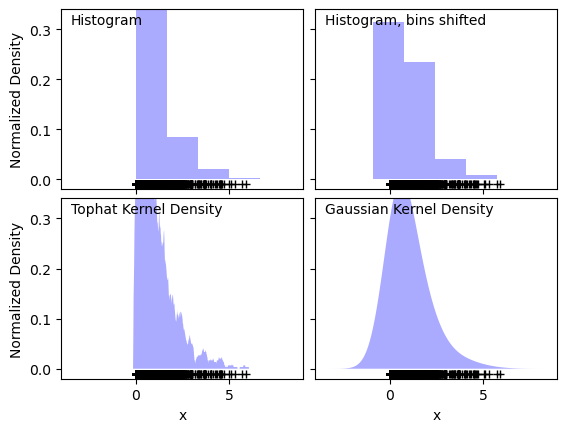

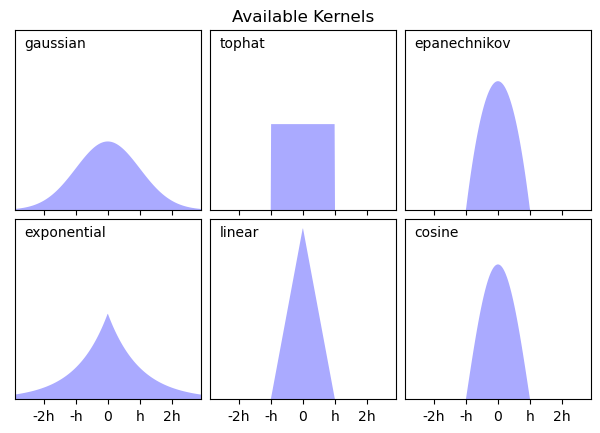

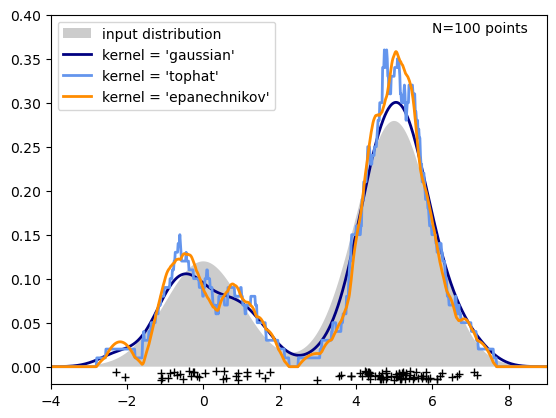

In [71]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from sklearn.neighbors import KernelDensity

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.random.exponential(scale = 1, size=1000)
X = X[:, np.newaxis]
#X = np.concatenate(
#    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
#)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc="#AAAAFF", density=True)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc="#AAAAFF", density=True)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel="tophat", bandwidth=0.15).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel("Normalized Density")

for axi in ax[1, :]:
    axi.set_xlabel("x")

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x


for i, kernel in enumerate(
    ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title("Available Kernels")

# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

TypeError: 'KernelDensity' object is not callable

In [8]:
X.shape

(100, 1)

In [ ]:
#create full table: check whether it work, it takes a while
df = pd.DataFrame()
k = 0
for file_name in os.listdir(repository):
    #print(file_name)
    complete_path = os.path.join(repository,file_name)
    new_df = pd.read_csv(complete_path, sep = "\t", parse_dates = [0,1])
    new_df = new_df.drop_duplicates(subset = ["UnitName","StartTS"])
    #new_df = combine_overlaps(new_df)
    if k % 20 == 0:
        print(k)
    k += 1
    df = pd.concat([df,new_df])

In [16]:
#otherwise import the following full dataset
df = pd.read_csv("deltaWithEverything_df.csv", parse_dates = [0,1])
df["StartTS"] = pd.to_datetime(df["StartTS"])
df["EndTS"] = pd.to_datetime(df["EndTS"])
df = df.sort_values(["UnitName","StartTS"])
df

StartTS               EndTS TimeZone     Status     Type  \
0      2021-07-14 09:00:00 2021-07-14 10:00:00      CET     Active   Forced   
1      2021-07-14 11:00:00 2021-07-14 23:59:00      CET     Active   Forced   
2      2021-07-15 15:00:00 2022-01-01 00:00:00      CET     Active   Forced   
3      2021-10-01 00:00:00 2021-10-01 01:00:00      CET     Active   Forced   
4      2021-10-01 01:00:00 2021-10-01 02:00:00      CET     Active   Forced   
...                    ...                 ...      ...        ...      ...   
573770 2021-09-16 00:00:00 2021-09-18 00:00:00      CET  Cancelled  Planned   
573771 2021-09-17 00:00:00 2021-09-18 00:00:00      CET  Cancelled  Planned   
573772 2022-06-19 00:00:00 2022-07-18 00:00:00      CET     Active  Planned   
573773 2022-07-10 00:00:00 2022-08-09 00:00:00      CET  Cancelled  Planned   
573774 2024-06-08 00:00:00 2024-07-01 00:00:00      CET     Active  Planned   

                AreaCode AreaTypeCode AreaName MapCode  PowerResourceEIC  \
0       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
1       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
2       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
3       10YES-REE------0          BZN   ES BZN      ES  18WABO1-12345-D7   
4       10YES-REE------0          CTA   ES CTA      ES  18WABO1-12345-D7   
...                  ...          ...      ...     ...               ...   
573770  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573771  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573772  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   
573773  10YHU-MAVIR----U          BZN   HU BZN      HU  15WUJPESTG2--STI   
573774  10YHU-MAVIR----U          CTA   HU CTA      HU  15WUJPESTG2--STI   

       UnitName     ProductionType  InstalledCapacity  AvailableCapacity  \
0       ABO¿O 1  Fossil Hard coal               341.7              230.0   
1       ABO¿O 1  Fossil Hard coal               341.7              220.0   
2       ABO¿O 1  Fossil Hard coal               341.7                0.0   
3       ABO¿O 1  Fossil Hard coal               341.7              190.0   
4       ABO¿O 1  Fossil Hard coal               341.7              210.0   
...         ...                ...                ...                ...   
573770    ÚJ_ST        Fossil Gas                33.0                0.0   
573771    ÚJ_ST        Fossil Gas                33.0                0.0   
573772    ÚJ_ST        Fossil Gas                33.0                0.0   
573773    ÚJ_ST        Fossil Gas                33.0                0.0   
573774    ÚJ_ST        Fossil Gas                33.0                0.0   

        Version                     Reason             UpTime  
0             1                    Failure                NaN  
1             7                    Failure    0 days 02:00:00  
2             5                    Failure    1 days 04:00:00  
3             1  Complementary Information   77 days 09:00:00  
4             1  Complementary Information    0 days 01:00:00  
...         ...                        ...                ...  
573770        2       Foreseen Maintenance    1 days 00:00:00  
573771        2       Foreseen Maintenance    1 days 00:00:00  
573772        1       Foreseen Maintenance  275 days 00:00:00  
573773        2  Complementary Information   21 days 00:00:00  
573774        1       Foreseen Maintenance  699 days 00:00:00  

[573775 rows x 17 columns]

In [17]:
#Combine overlaps fo that every generator is only at one state at the time
df = combine_overlaps(df)


percentage of rows parsed = 0.00%
percentage of rows parsed = 1.00%
percentage of rows parsed = 2.00%
percentage of rows parsed = 3.00%
percentage of rows parsed = 4.00%
percentage of rows parsed = 5.00%
percentage of rows parsed = 6.00%
percentage of rows parsed = 7.00%
percentage of rows parsed = 8.00%
percentage of rows parsed = 9.00%
percentage of rows parsed = 10.00%
percentage of rows parsed = 11.00%
percentage of rows parsed = 12.00%
percentage of rows parsed = 13.00%
percentage of rows parsed = 14.00%
percentage of rows parsed = 15.00%
percentage of rows parsed = 16.00%
percentage of rows parsed = 17.00%
percentage of rows parsed = 18.00%
percentage of rows parsed = 19.00%
percentage of rows parsed = 20.00%
percentage of rows parsed = 21.00%
percentage of rows parsed = 22.00%
percentage of rows parsed = 23.00%
percentage of rows parsed = 24.00%
percentage of rows parsed = 25.00%
percentage of rows parsed = 26.00%
percentage of rows parsed = 27.00%
percentage of rows parsed = 28

## Occurances by generator during the year.
In this sections we consider for every week of the year how many outages happen in average during that week.
We observe that no clear dependence arises between part of the year and number of outages.

In [107]:
#import all dataframes and for each week count number of occurances
count_df = df.groupby(["ProductionType","MapCode","Reason",pd.Grouper(key = "StartTS", freq = "M")]).count()
count_df = count_df.rename(columns = {"Status": "Count"})
count_df = count_df.reset_index() #ungroups
count_df["Week"] = count_df["StartTS"].apply(get_week) #get week number
count_df = count_df[count_df["StartTS"] < datetime.datetime(2022, 1, 1, 1, 00,00)] #remove predictions


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


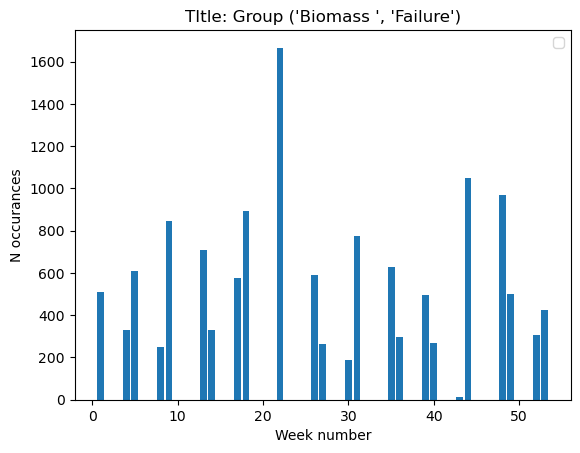

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


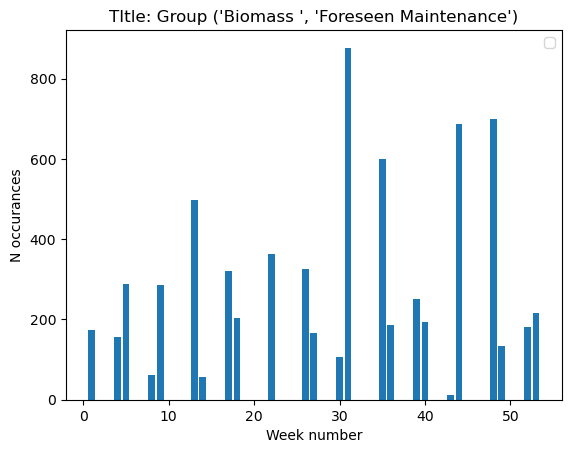

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


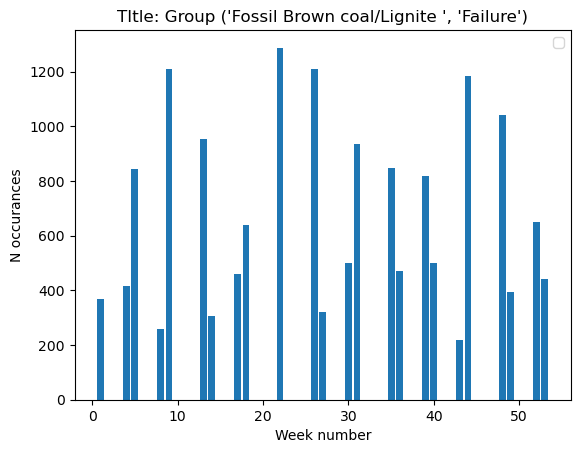

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


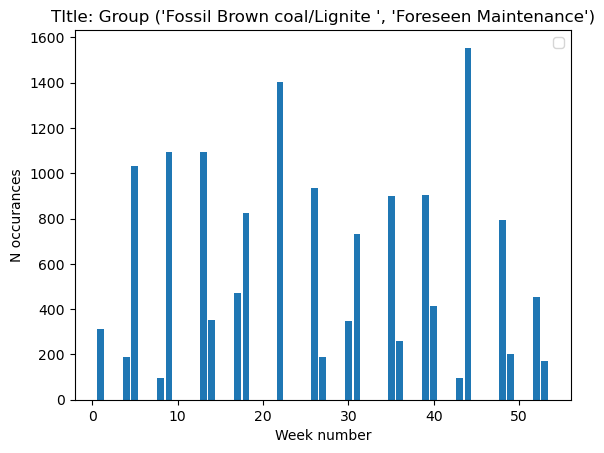

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


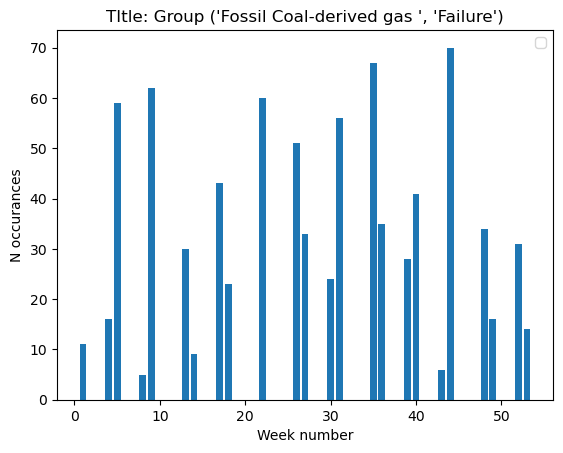

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


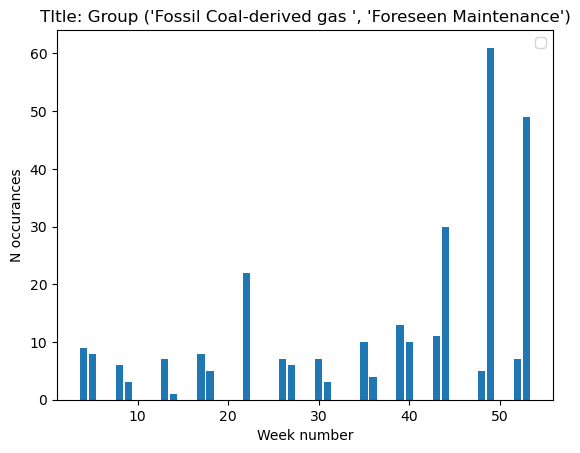

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


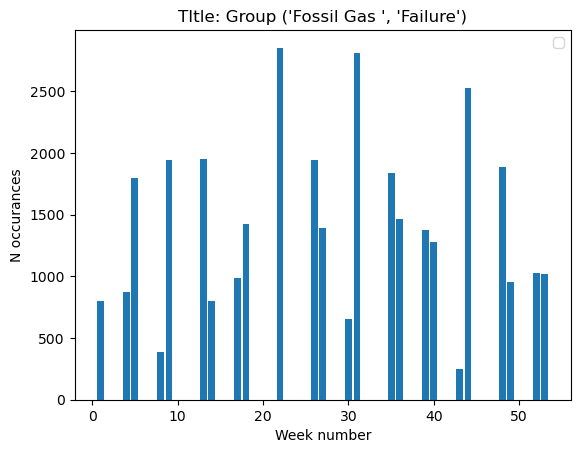

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


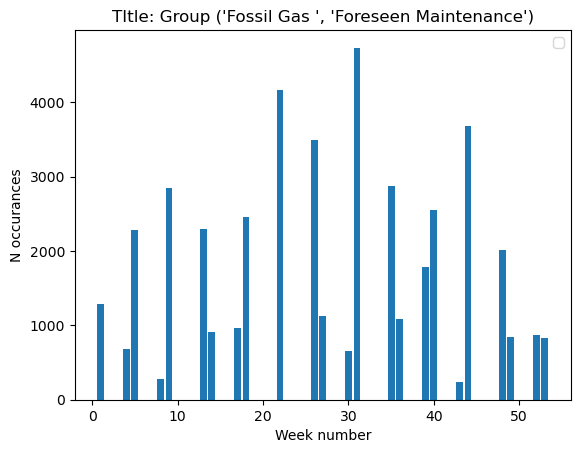

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


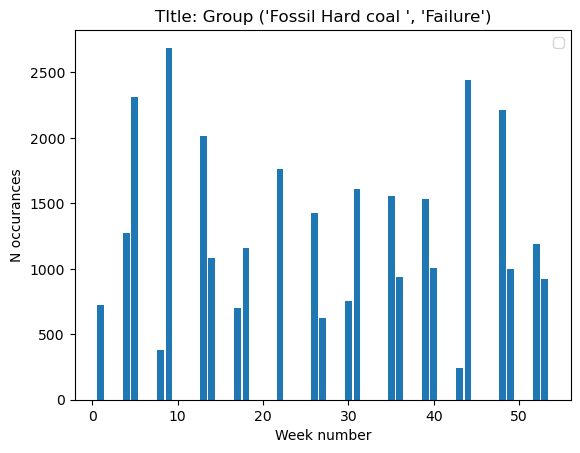

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


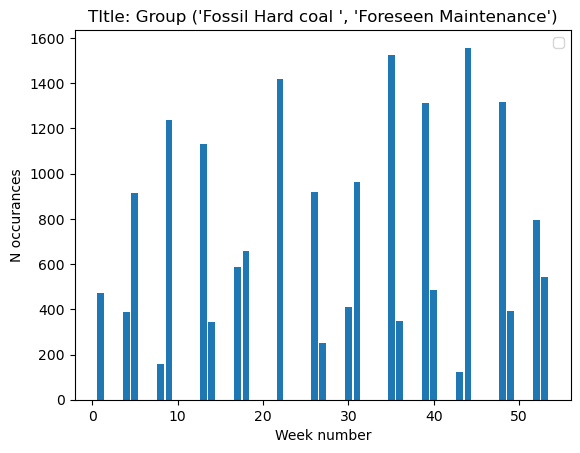

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


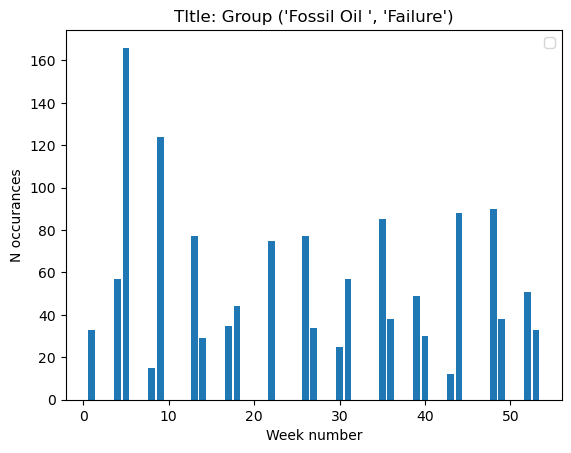

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


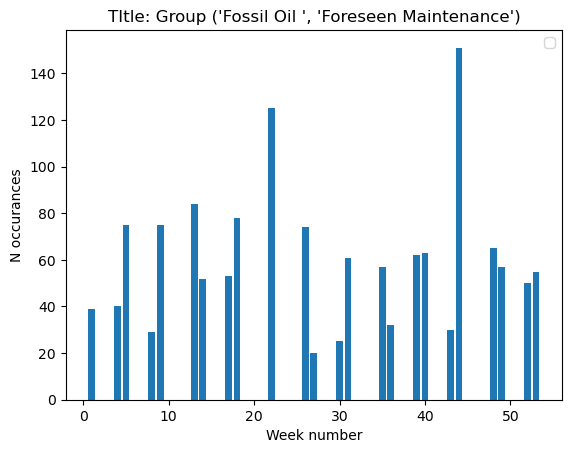

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


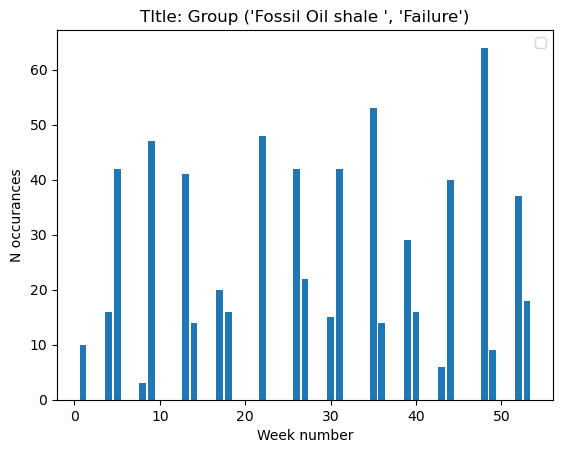

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


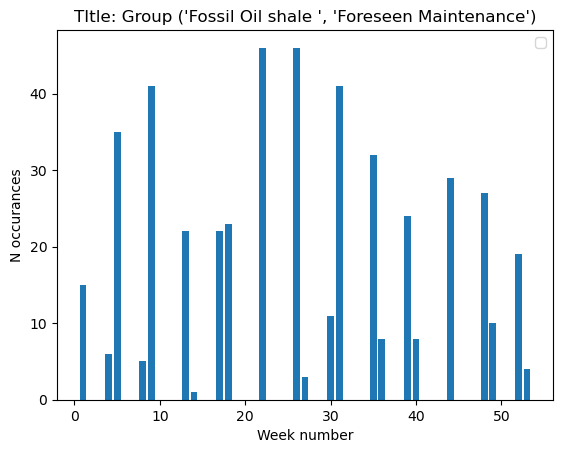

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


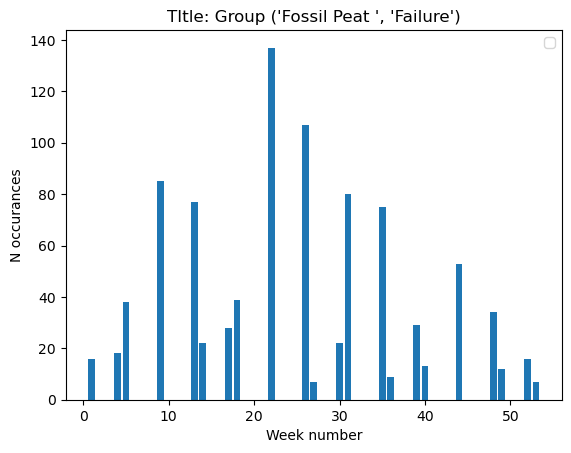

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


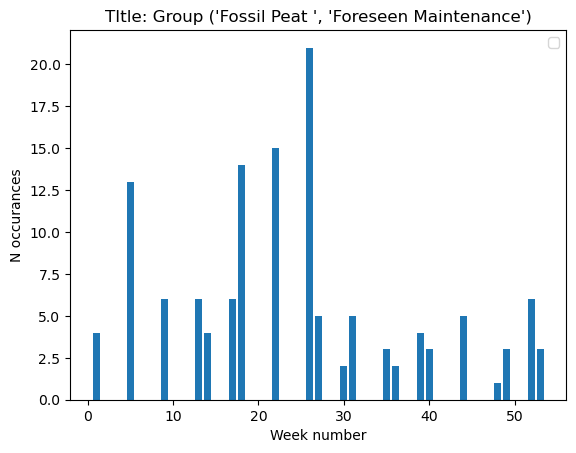

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


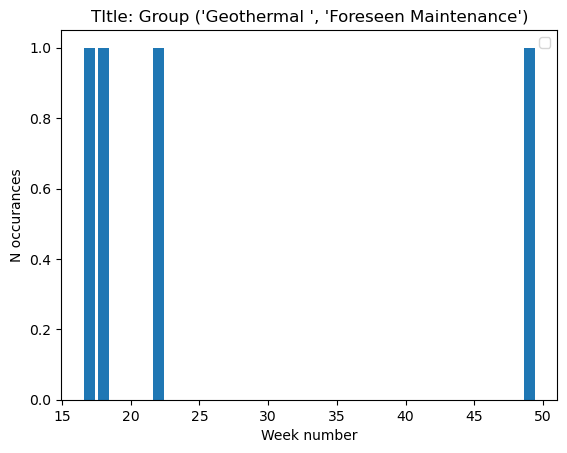

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


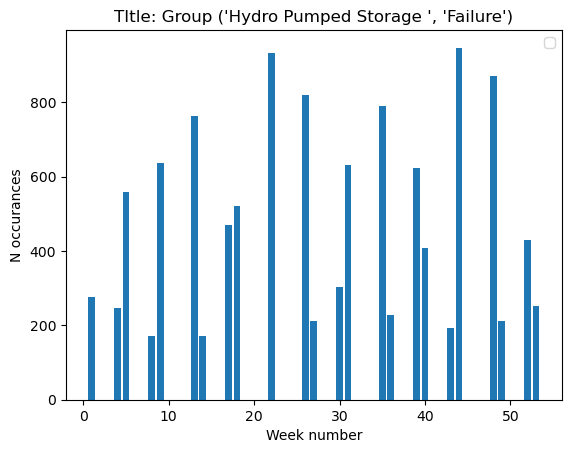

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


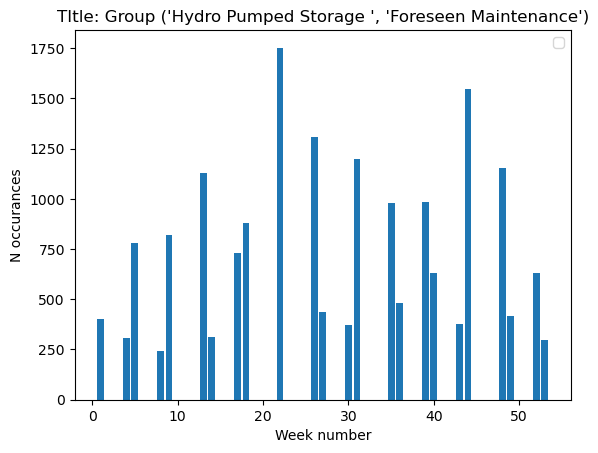

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


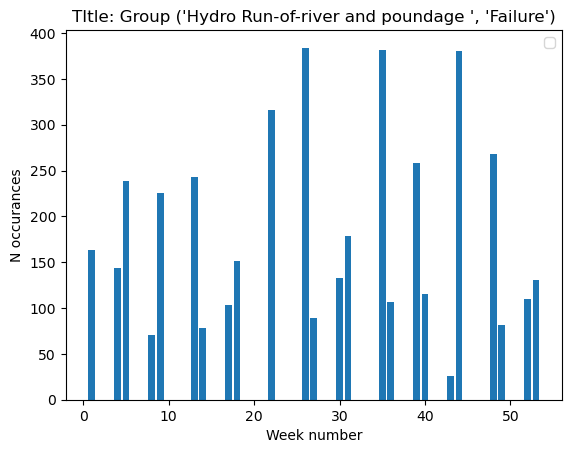

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


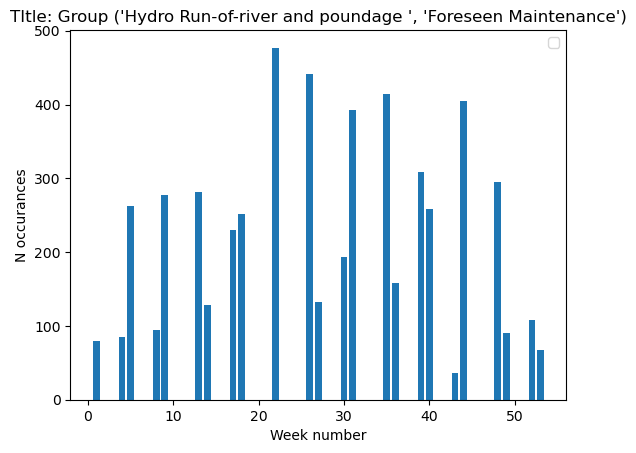

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


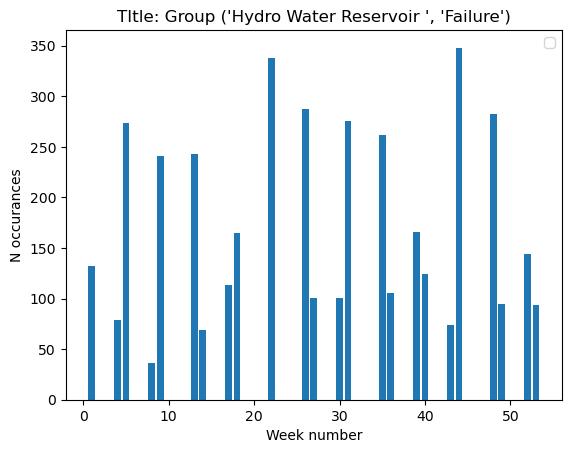

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


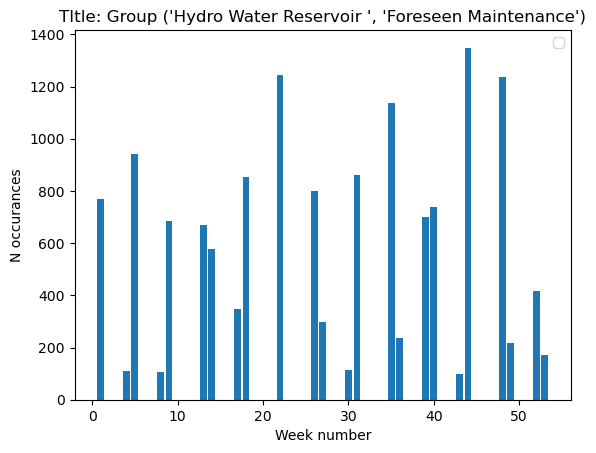

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


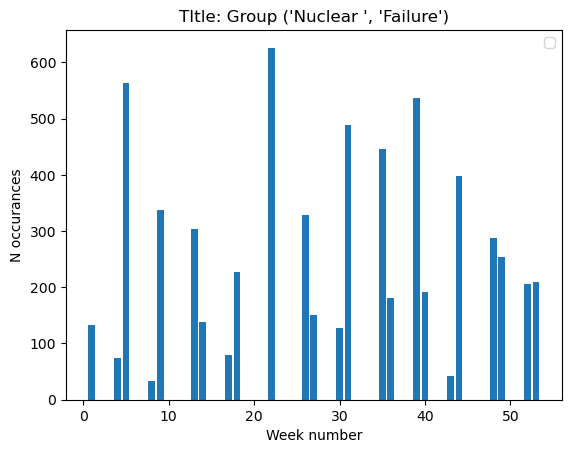

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


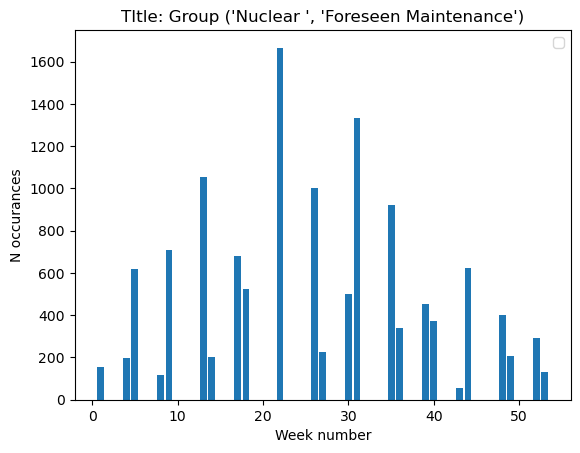

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


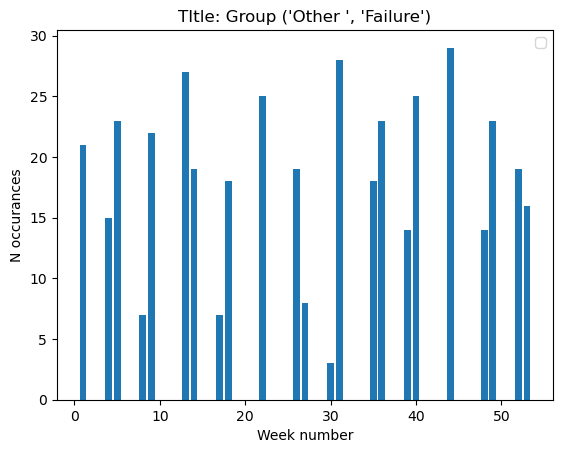

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


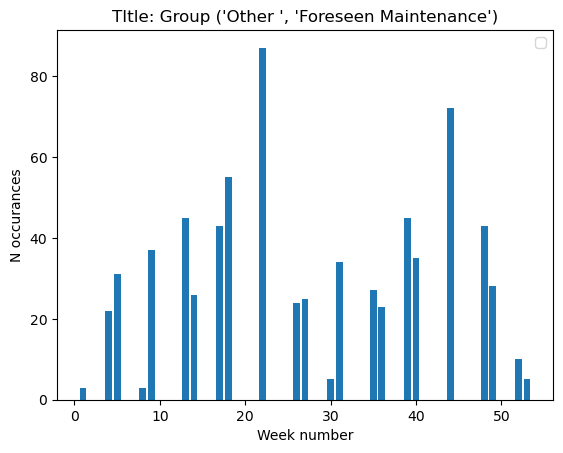

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


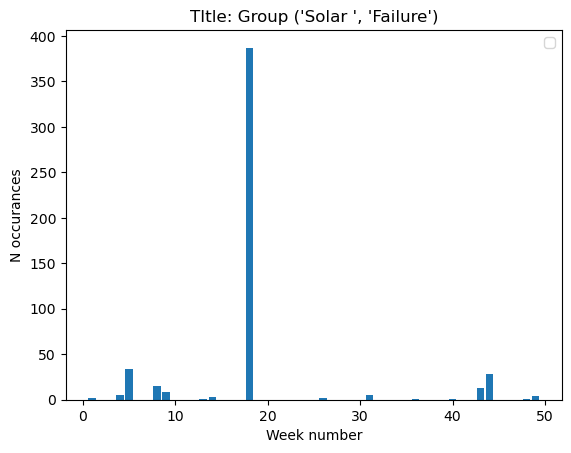

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


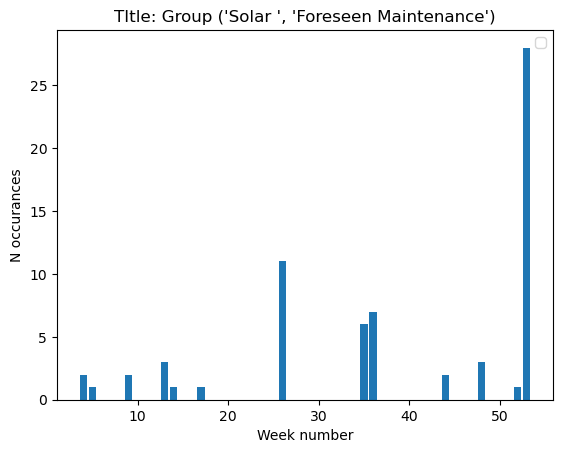

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


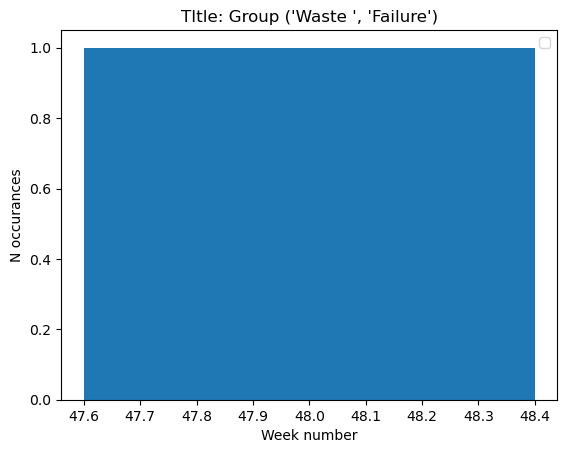

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


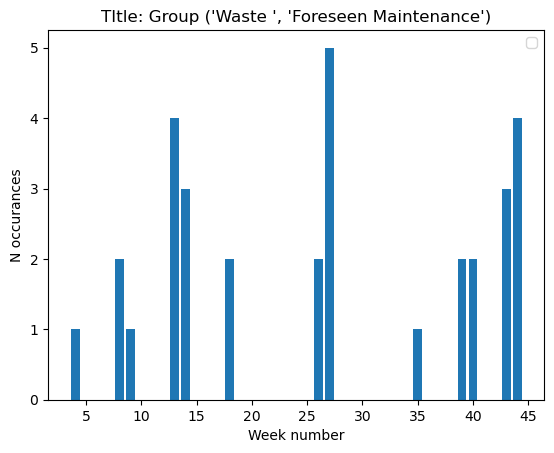

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


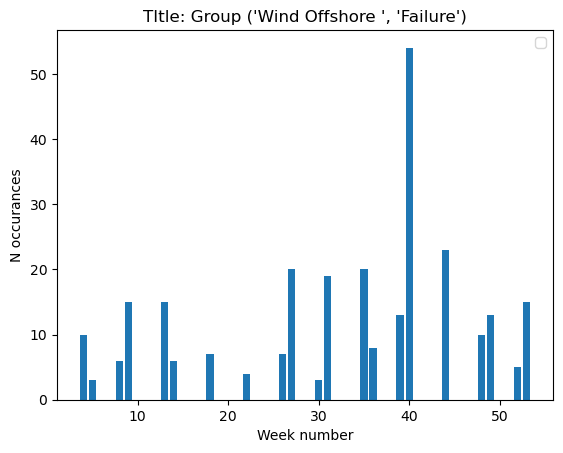

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


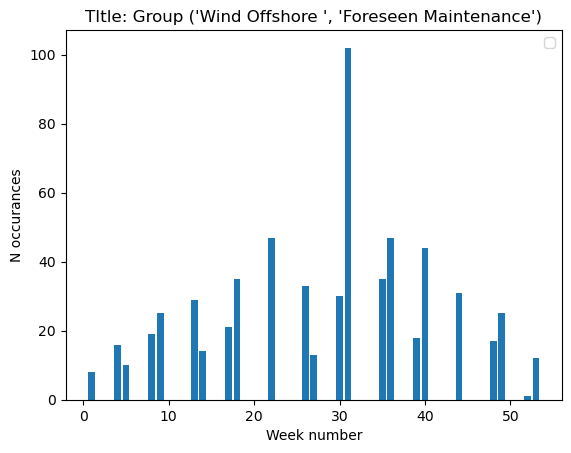

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


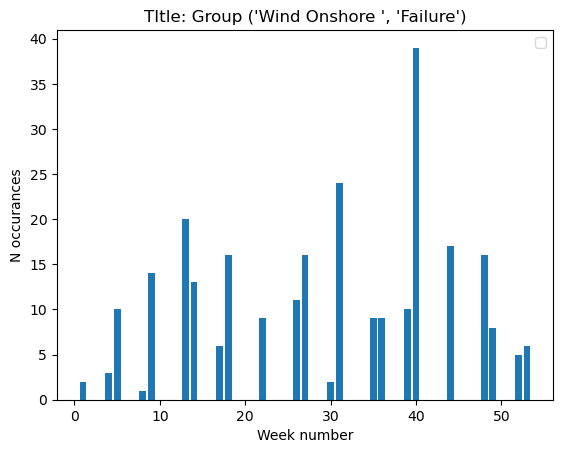

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


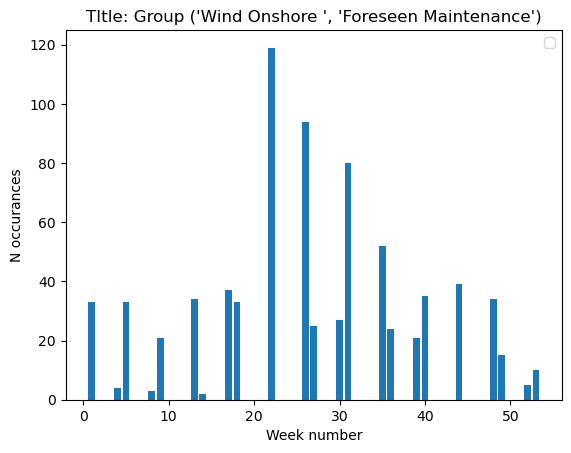

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


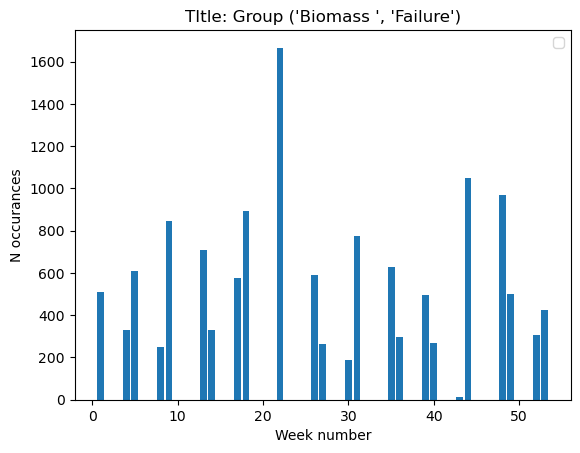

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


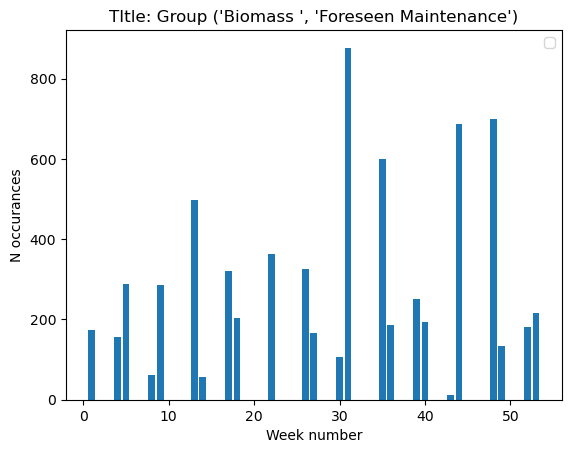

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


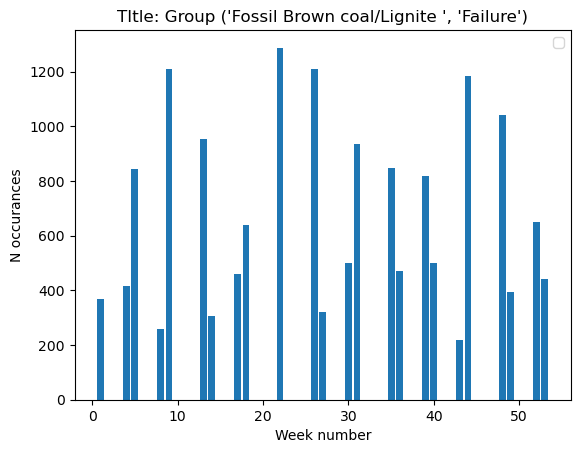

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


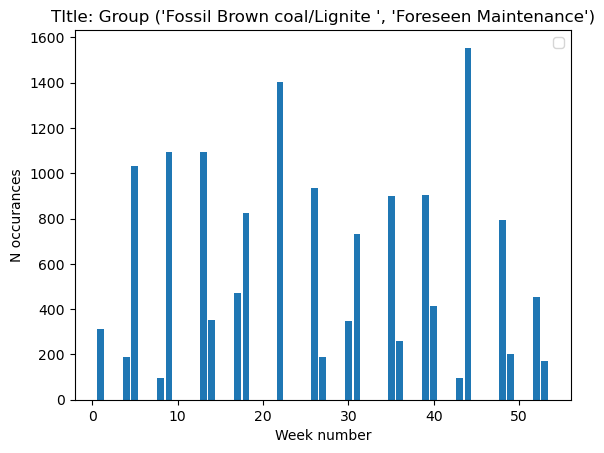

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


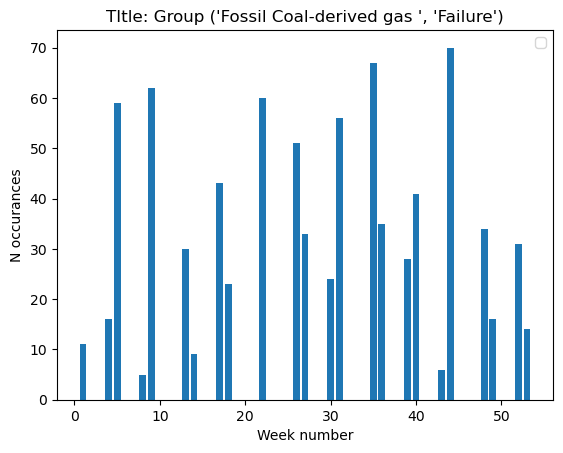

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


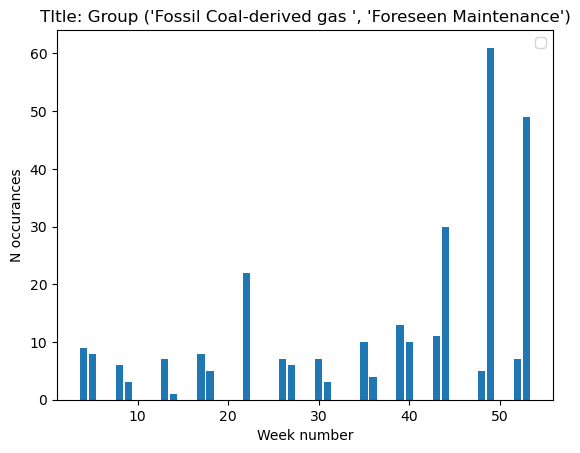

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


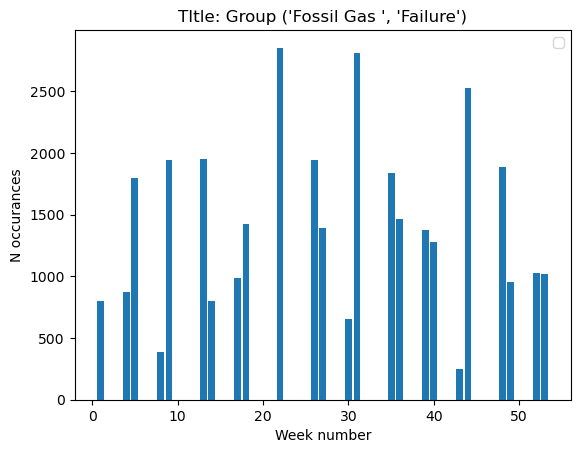

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


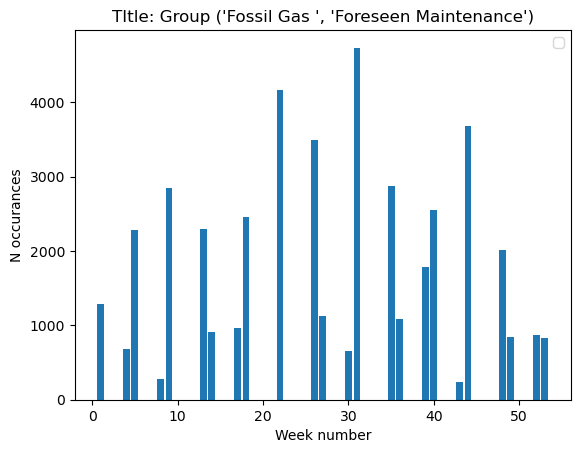

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


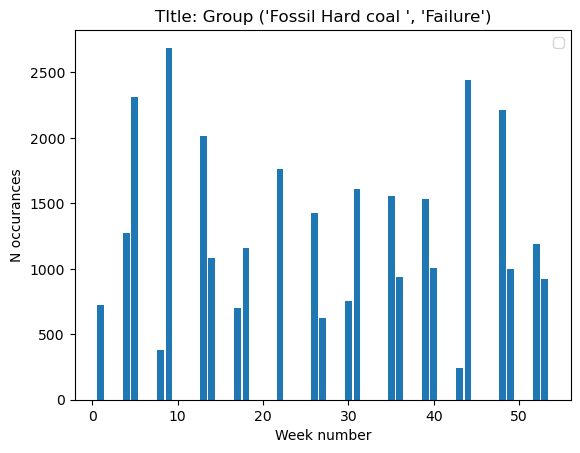

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


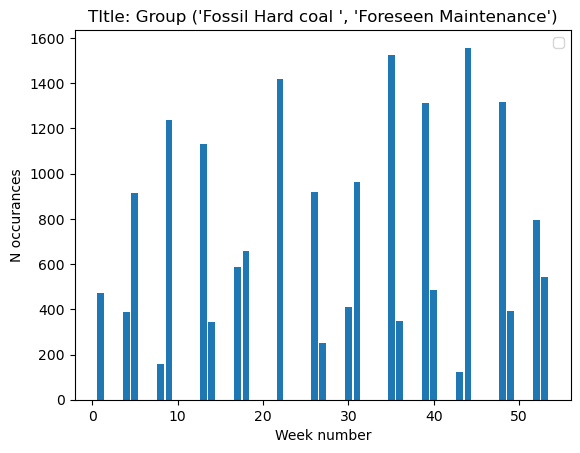

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


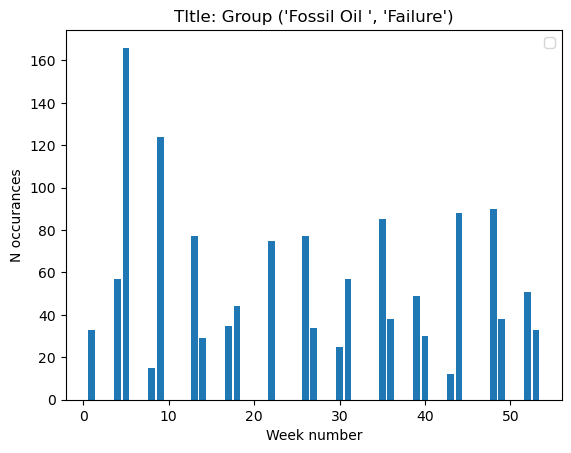

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


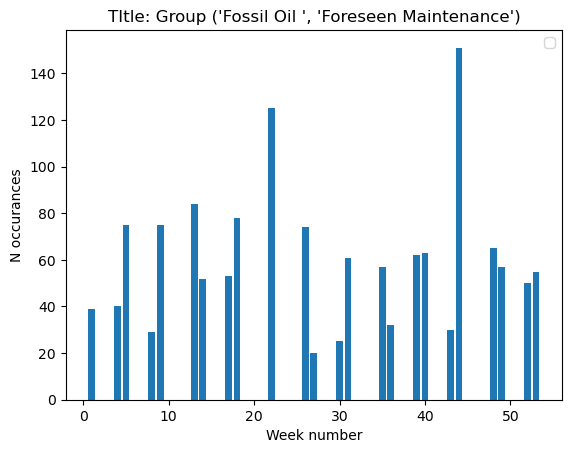

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


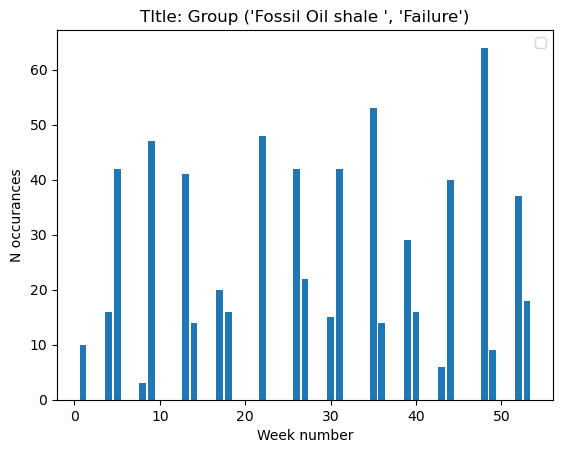

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


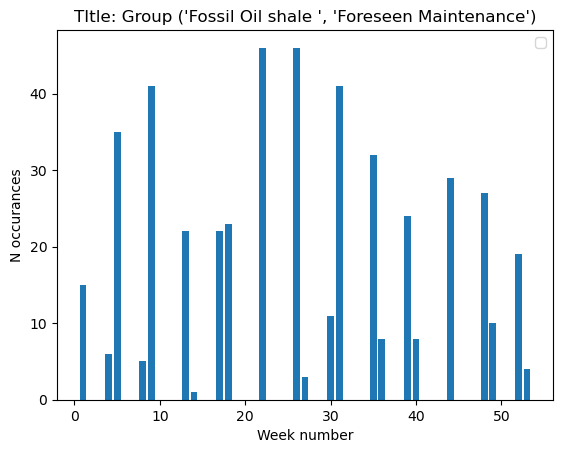

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


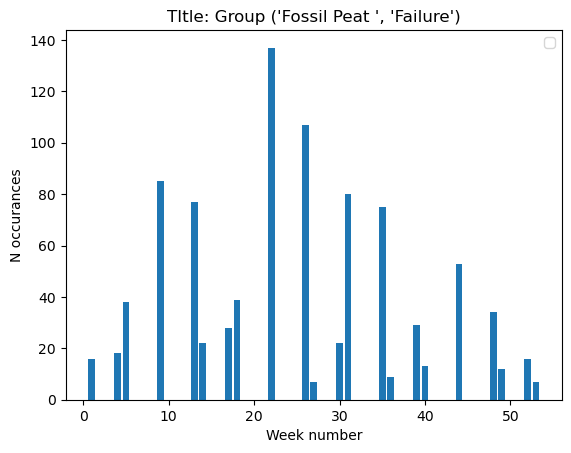

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


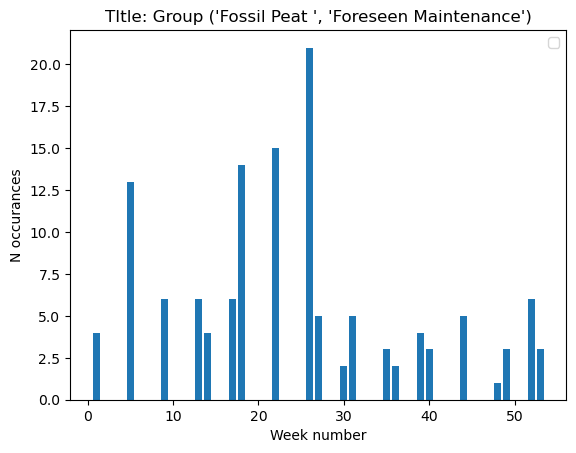

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


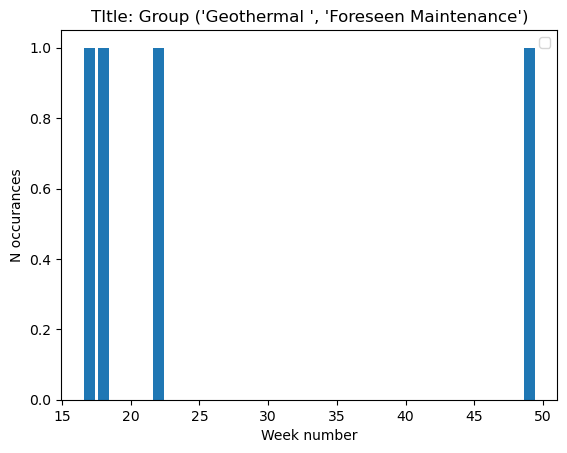

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


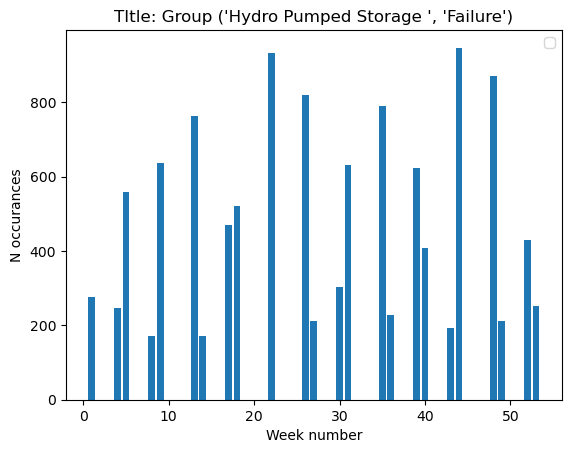

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


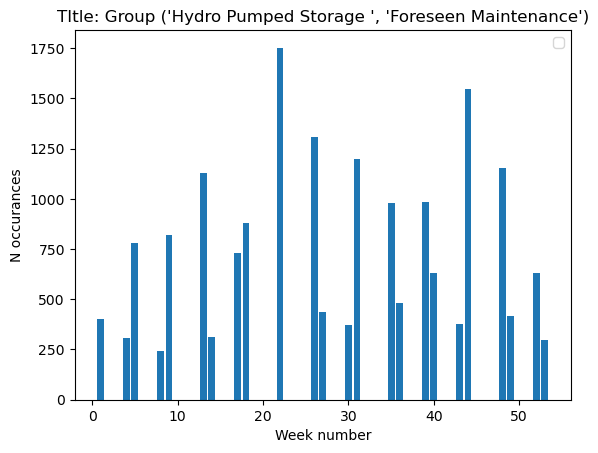

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


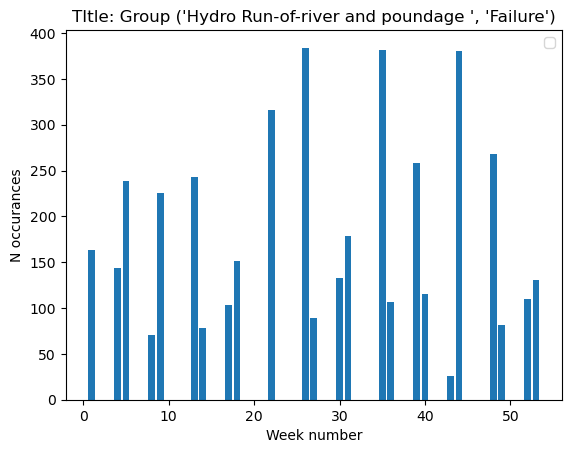

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


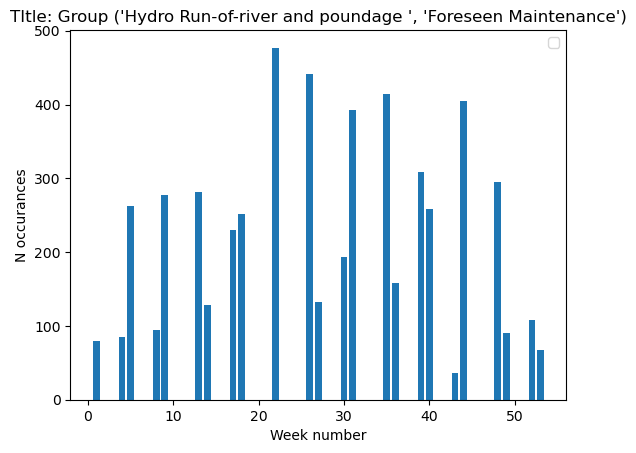

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


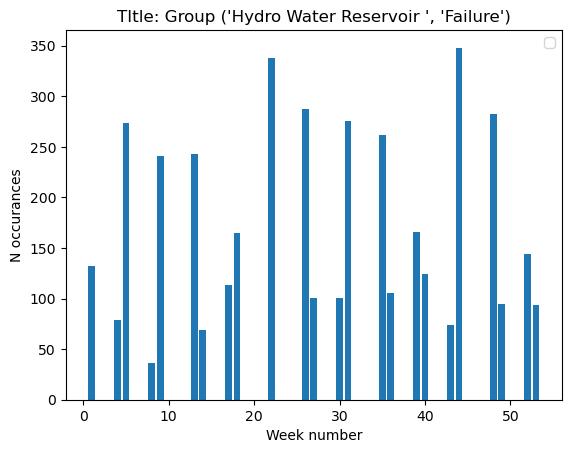

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


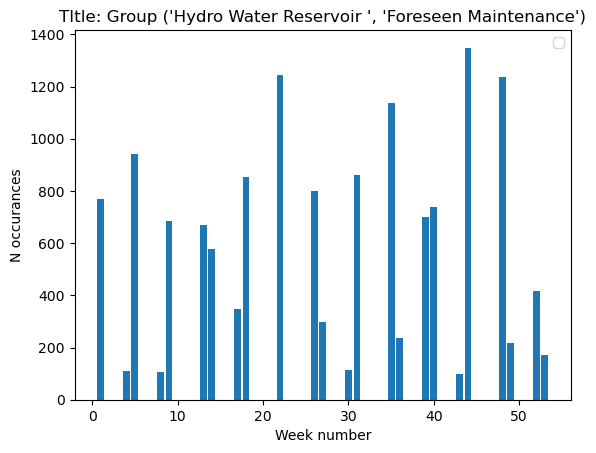

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


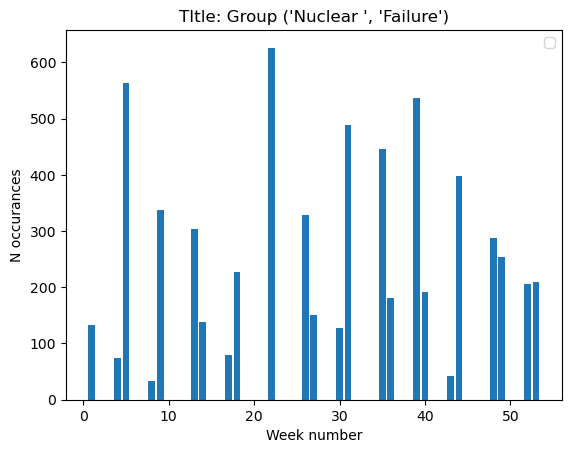

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


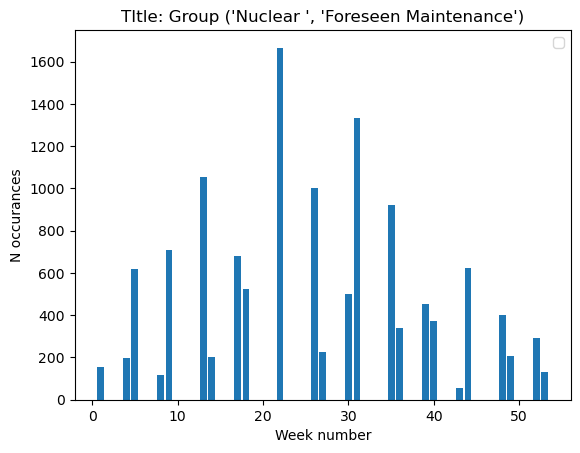

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


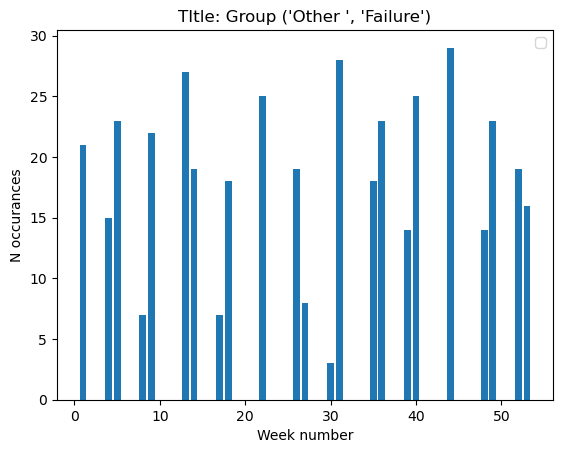

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


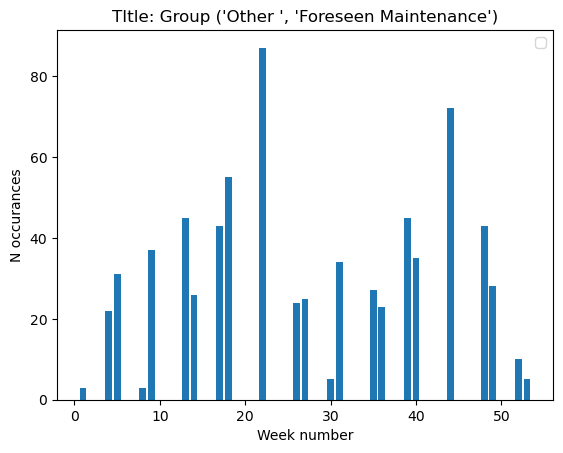

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


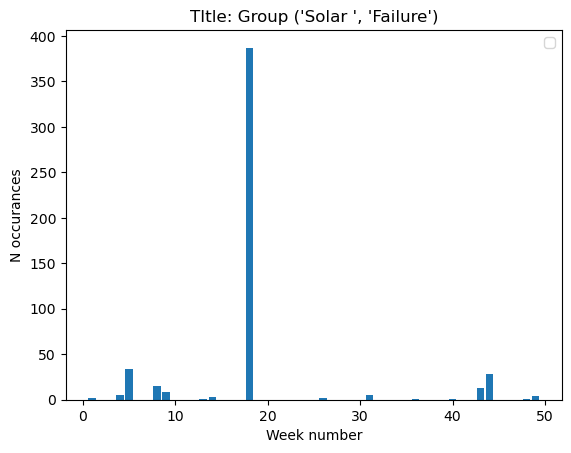

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


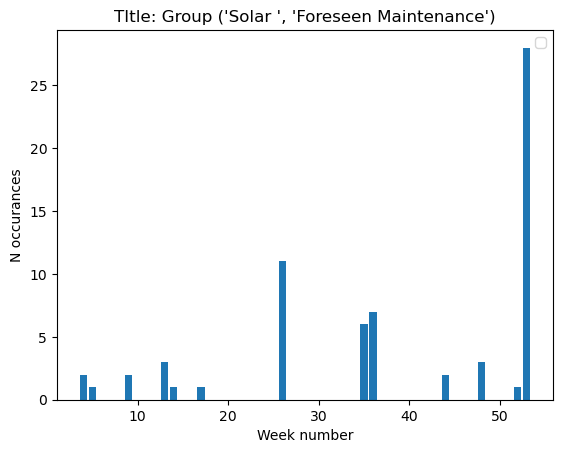

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


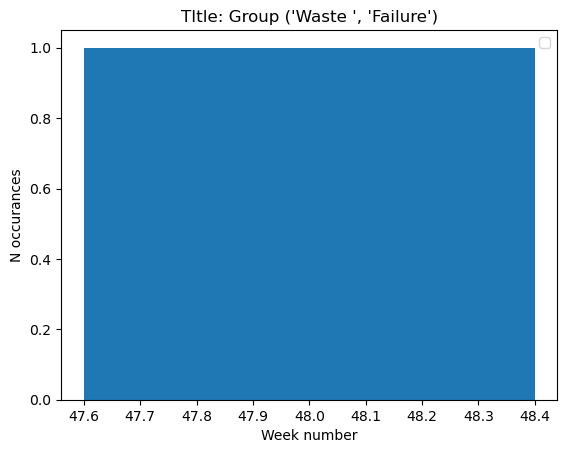

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


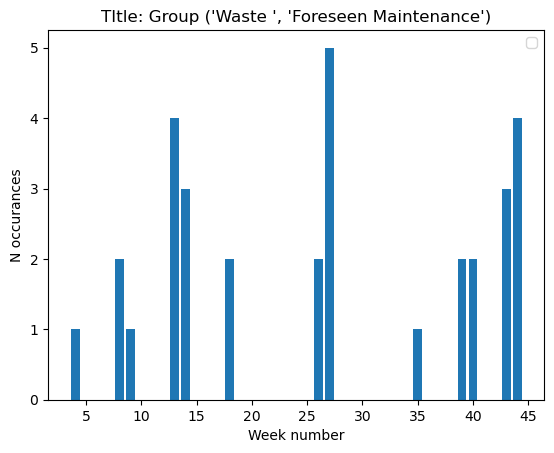

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


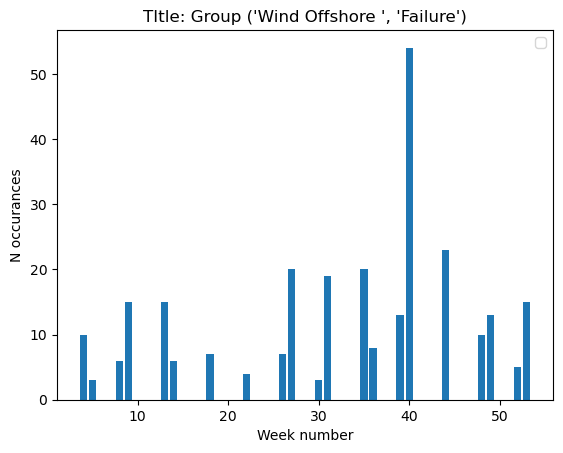

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


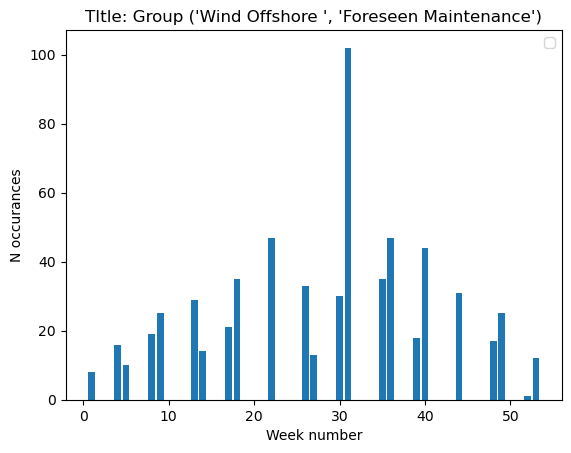

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


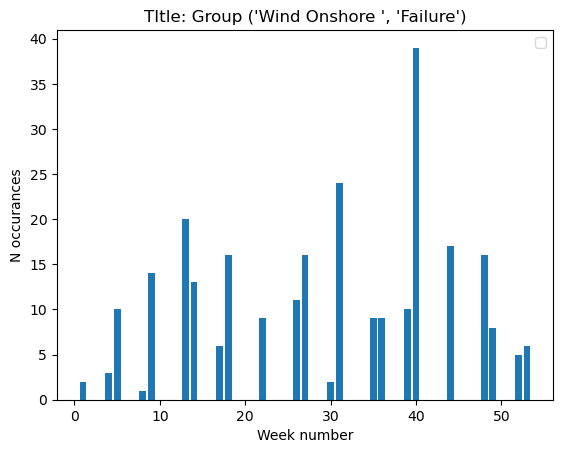

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


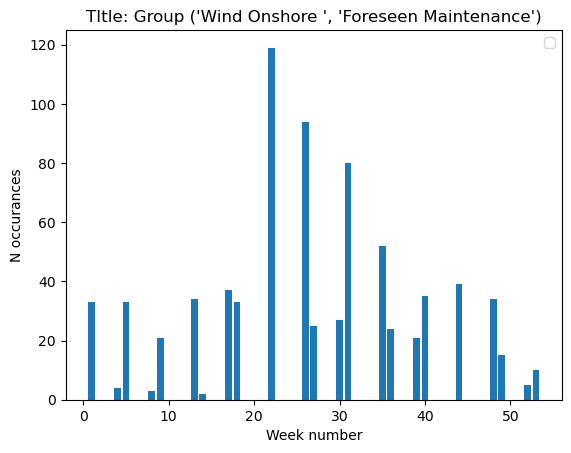

In [108]:

#calculate average occurances
n_years = 8
distributions = count_df.groupby(["ProductionType","Reason","Week"])["Count"].sum() #count contingencees for every week
#distributions["Count"] = distributions["Count"]/n_years
distributions = distributions.reset_index()
grouped_distributions = distributions.groupby(["ProductionType","Reason"])

#plot for every type of generator 
for (group_name, group_df) in grouped_distributions:
    if group_name[1] in ["Failure","Foreseen Maintenance"]: #plot only failures and Foressen Maintenances
        plt.figure()
        plt.bar(group_df["Week"],group_df["Count"])
        plt.xlabel('Week number')
        plt.ylabel('N occurances')
        plt.title( f'TItle: Group {group_name}')
        plt.legend()
        plt.show()
        
#plot for every type of generator 
for (group_name, group_df) in grouped_distributions:
    if group_name[1] in ["Failure","Foreseen Maintenance"]: #plot only failures and Foressen Maintenances
        plt.figure()
        plt.bar(group_df["Week"],group_df["Count"])
        plt.xlabel('Week number')
        plt.ylabel('N occurances')
        plt.title( f'TItle: Group {group_name}')
        plt.legend()
        plt.show()

**Why are there some weeks without failures???**

In [109]:
#weeks with failures:
weeks_with_failures = distributions[(distributions["Reason"]=="Failure")]["Week"].unique()
print(weeks_with_failures)

[ 1  4  5  8  9 13 14 17 18 22 26 27 30 31 35 36 39 40 43 44 48 49 52 53]


## State time modeling
In this section we model the time a generator spends in a certain state.
We model the random variable time in each state with a exponential distribution using the maximum likelyhood estimator (MLE).


In [110]:
#Change state_column to look ad different state distributions
state_column = "Type"

#def state_time_distribution_fitting(df, state_column):

states = list(df[state_column].unique())
delta_df = df
delta_df = delta_df.sort_values(by = ["UnitName", "StartTS"])

for state in states:
    #calculate time spend in each state
    delta_df[state+"Time"] = [np.datetime64("NaT")]*df.shape[0]
    state_df = delta_df[delta_df[state_column] == state]
    delta_df.loc[delta_df[state_column] == state, state+"Time"] = state_df["EndTS"] - state_df["StartTS"]
    delta_df[state+"Time"] = (delta_df[state+"Time"] /  np.timedelta64(1, 's')) / (60 * 60 * 24)
    
for unit, unit_df in delta_df.groupby("UnitName"):                             
    shifted_endts = pd.to_datetime(np.array([np.datetime64("NaT")] + list(unit_df["EndTS"][:-1])))
    start_ts = delta_df.loc[delta_df["UnitName"] == unit, "StartTS"]
    delta_df.loc[delta_df["UnitName"] == unit, "UpTime"] = start_ts - shifted_endts

delta_df["UpTime"] = (delta_df["UpTime"] /  np.timedelta64(1, 's')) / (60 * 60 * 24)
delta_df.loc[delta_df["UpTime"] == 0, "UpTime"] = np.nan

states = states + ["Up"]


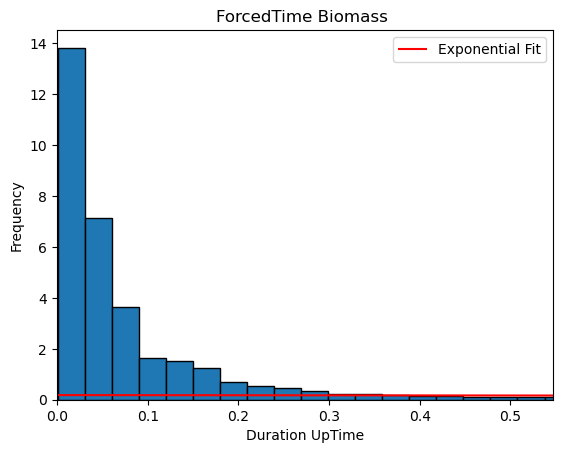

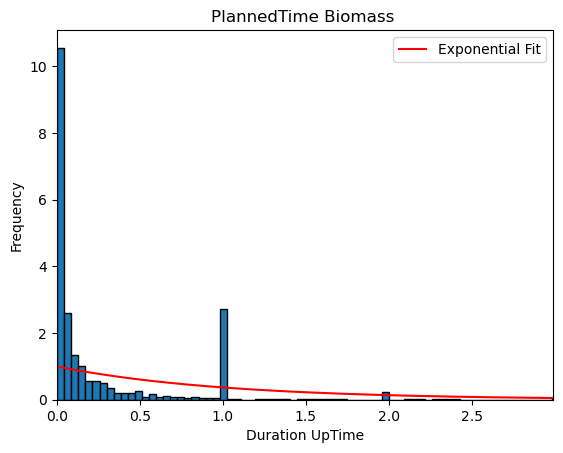

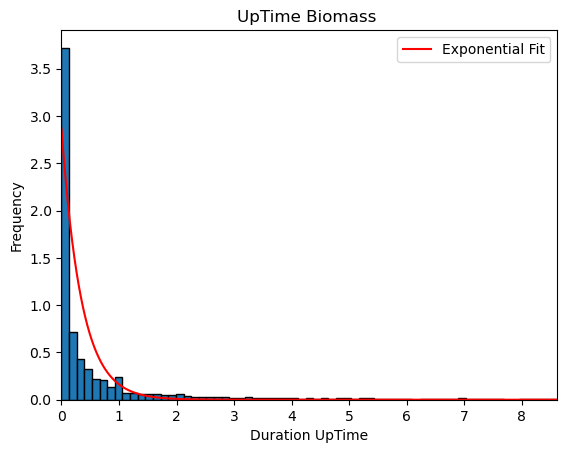

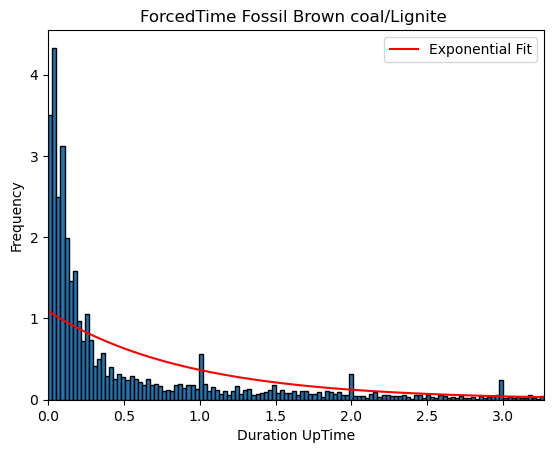

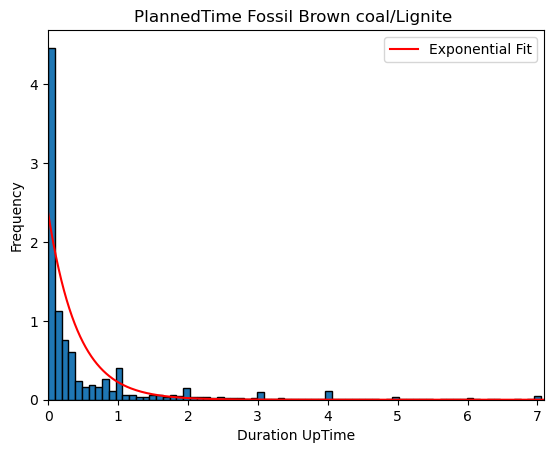

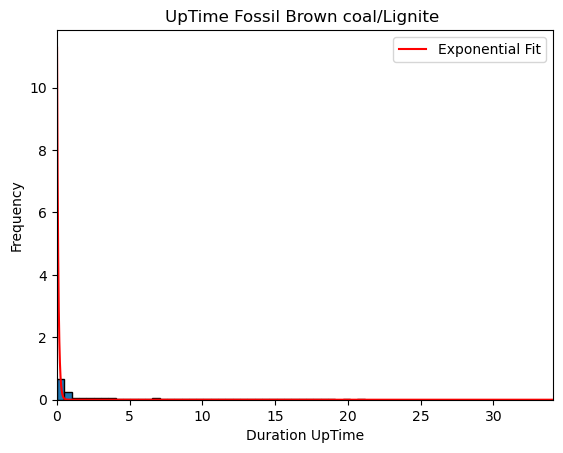

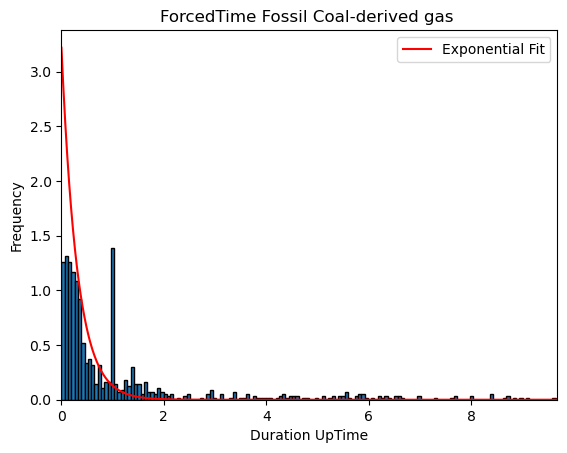

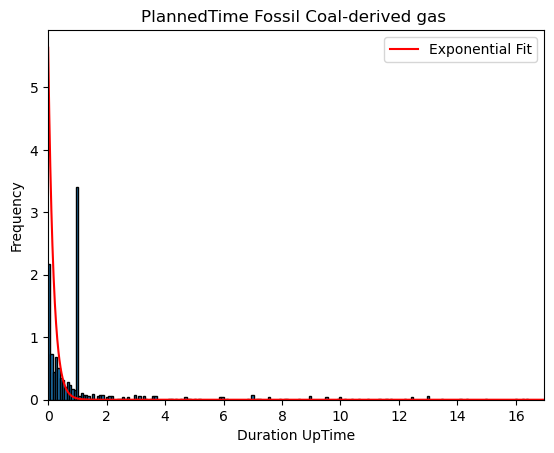

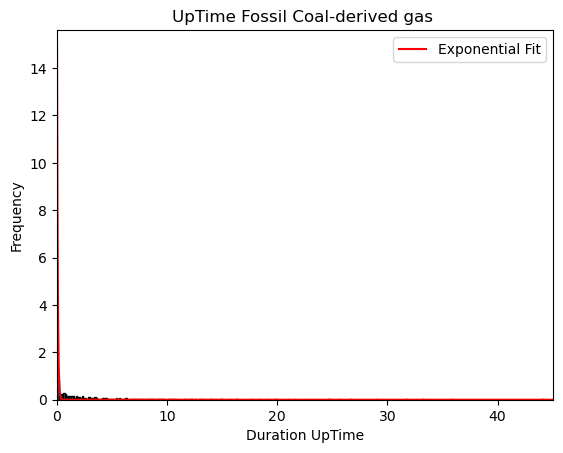

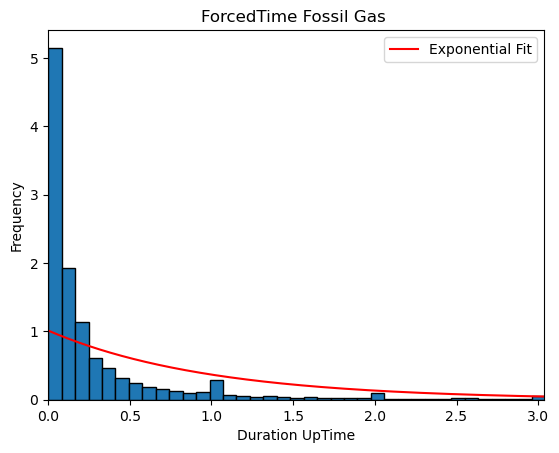

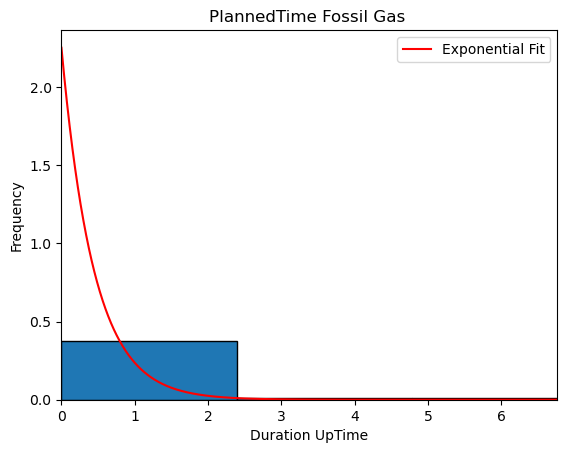

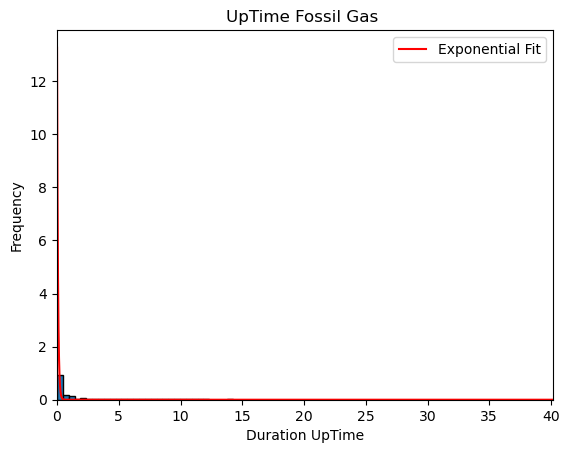

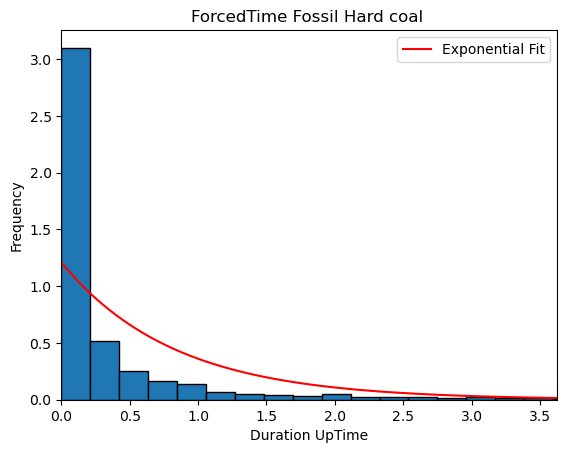

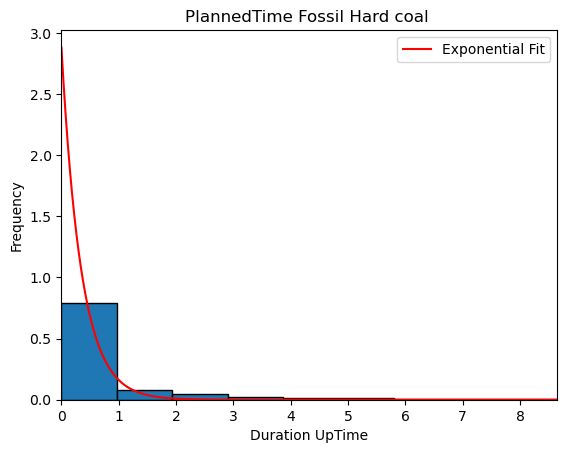

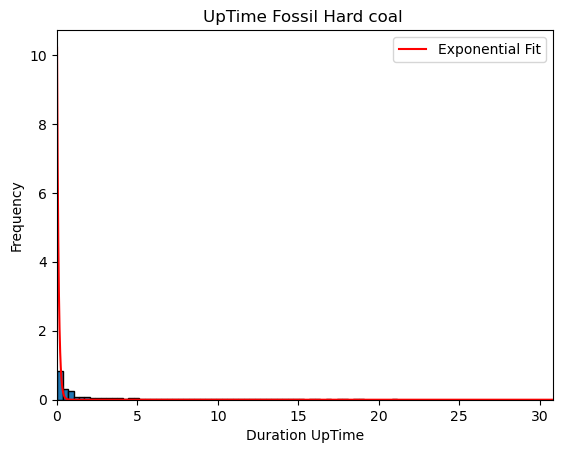

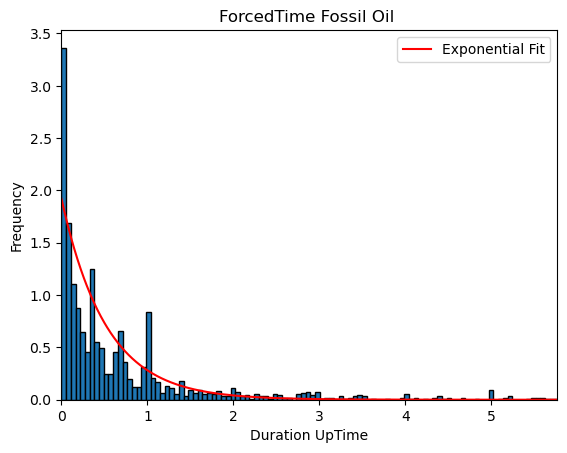

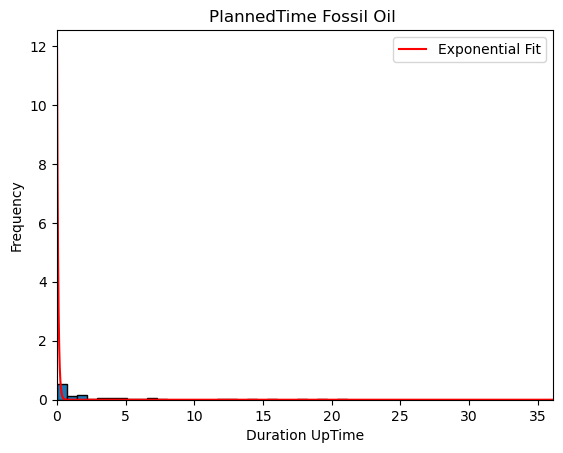

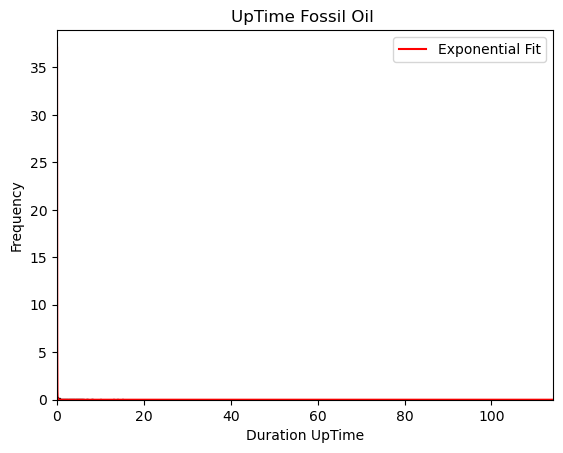

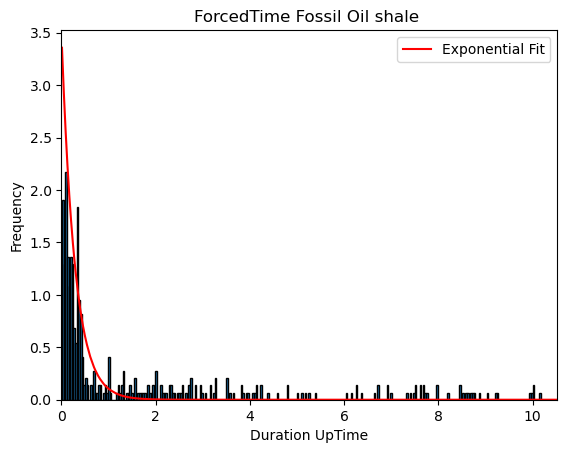

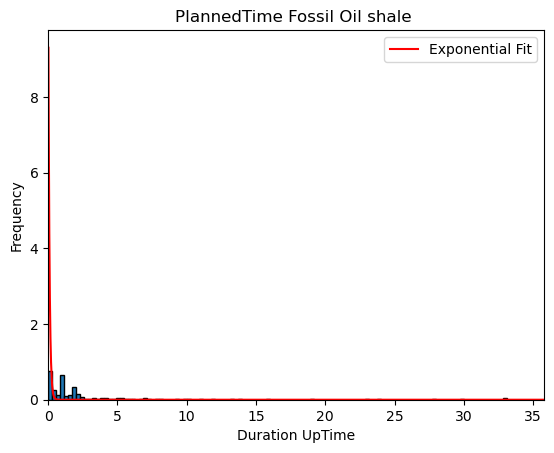

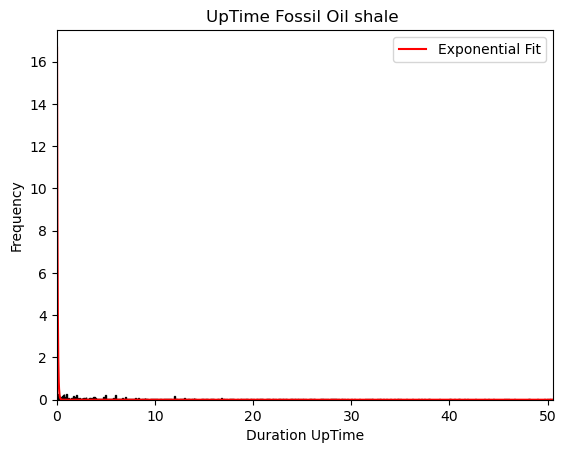

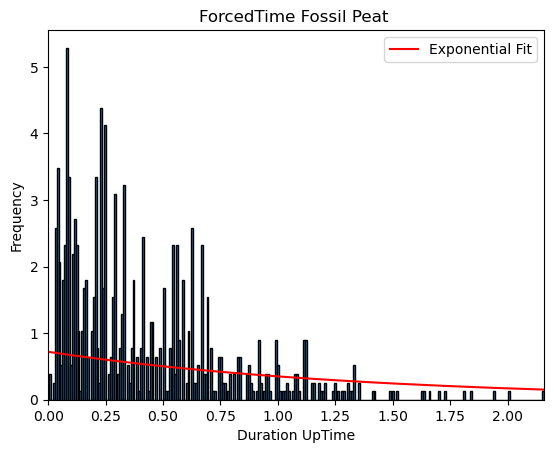

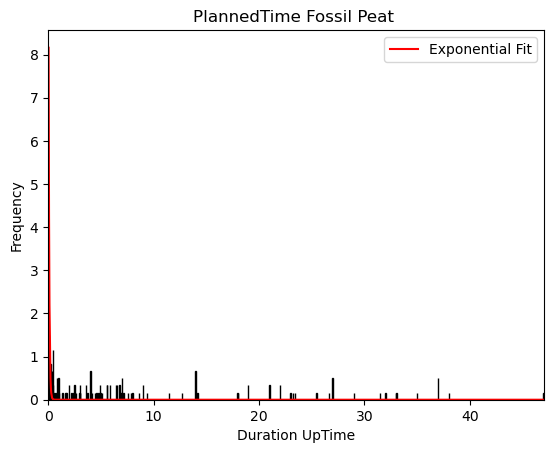

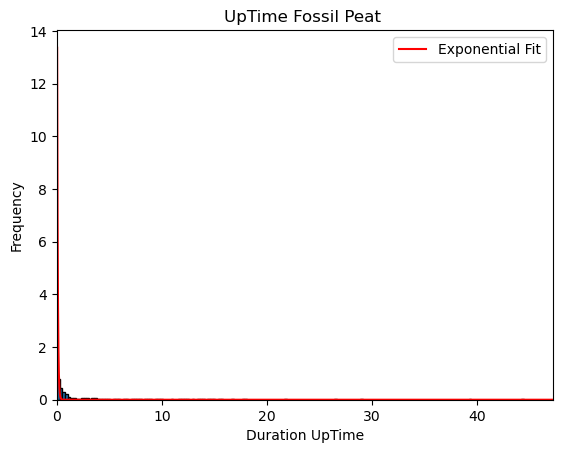

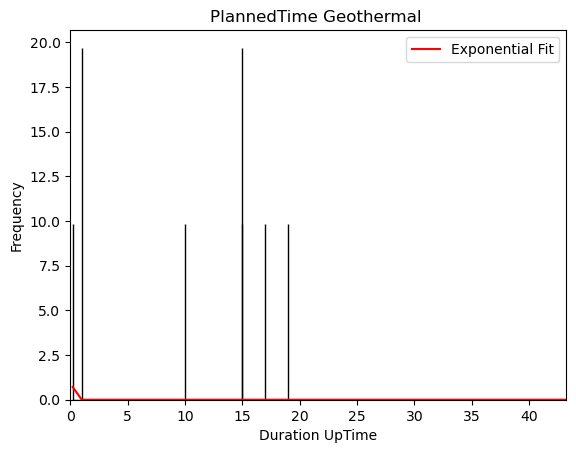

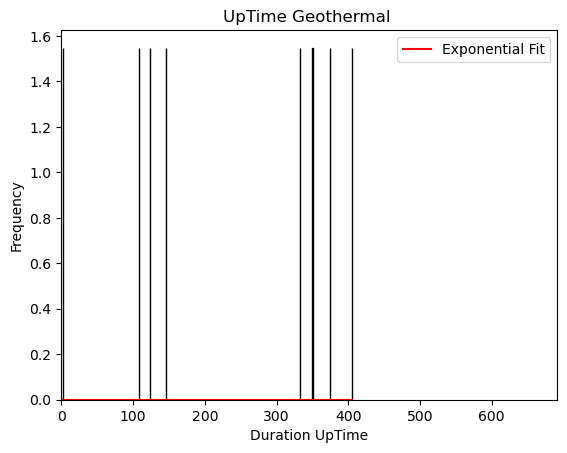

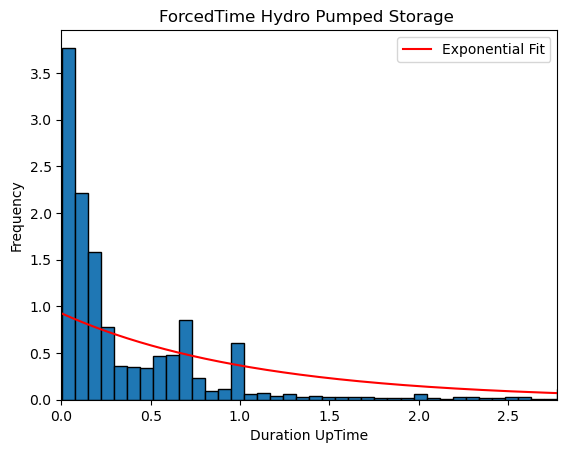

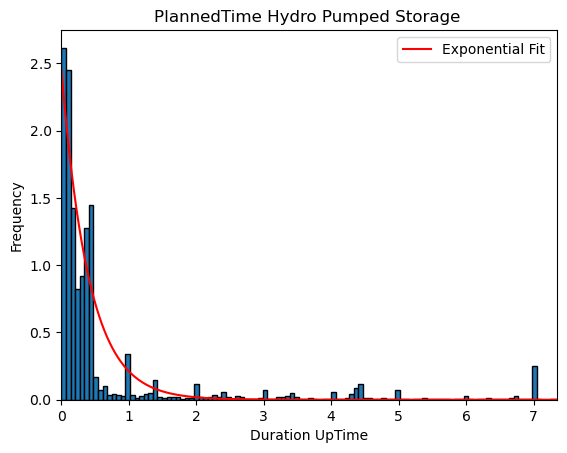

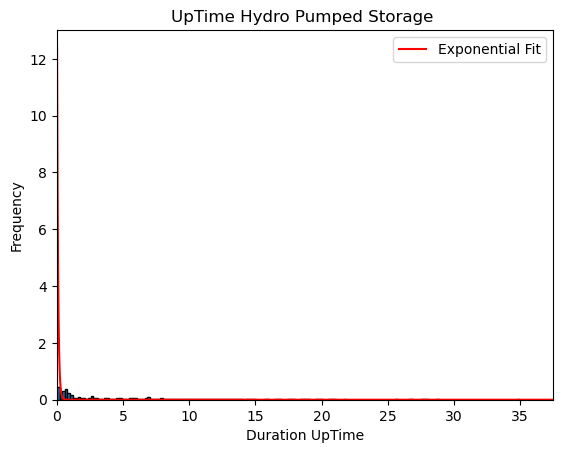

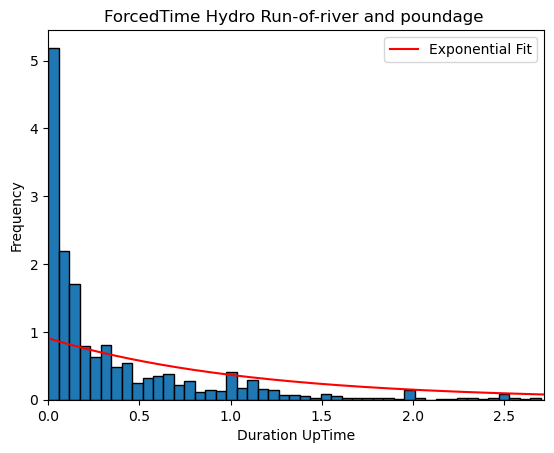

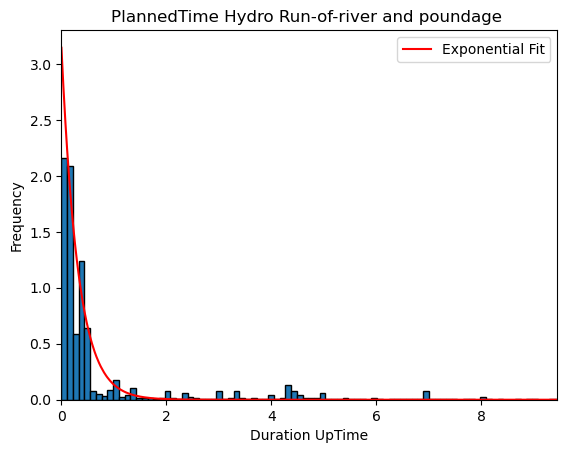

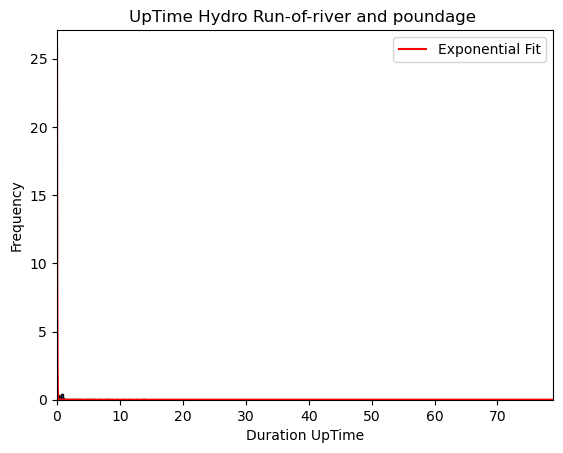

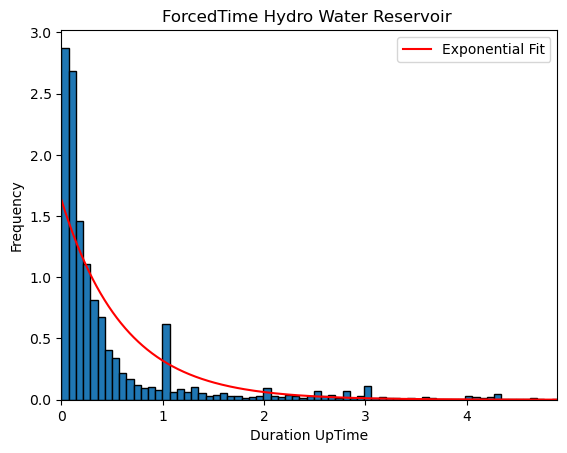

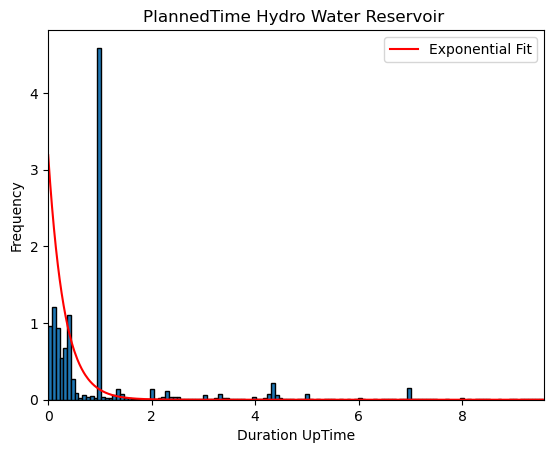

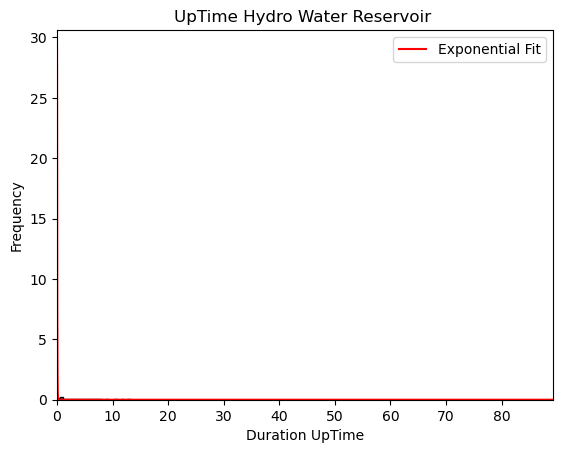

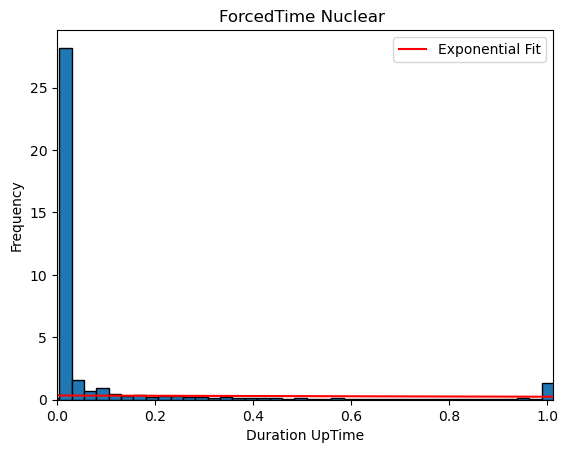

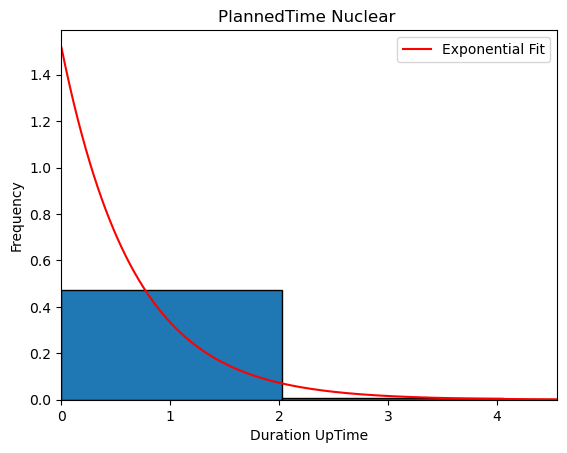

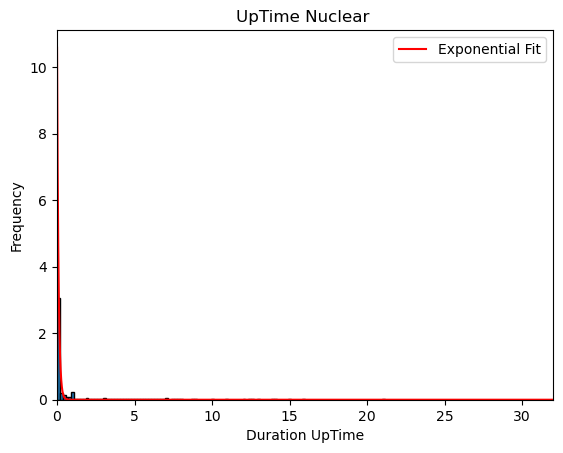

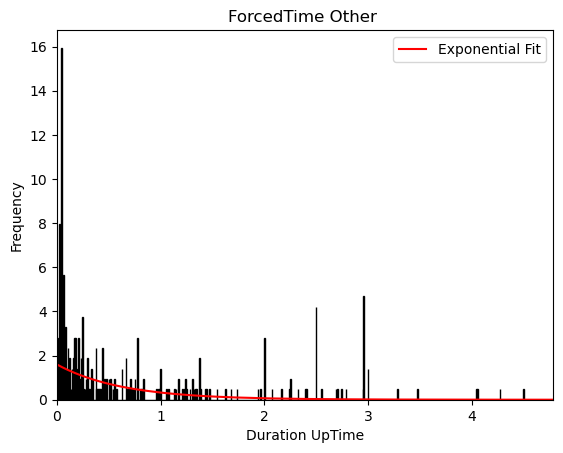

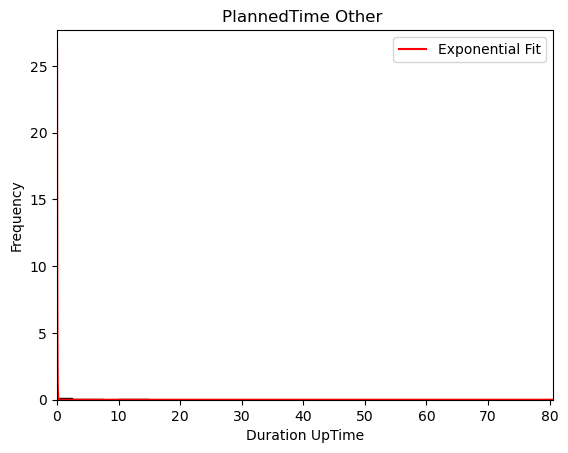

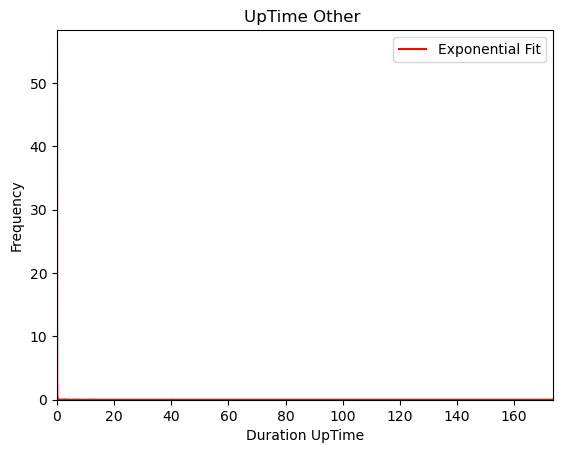

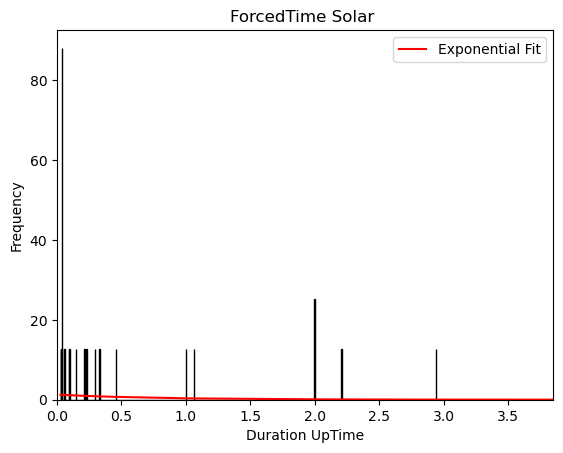

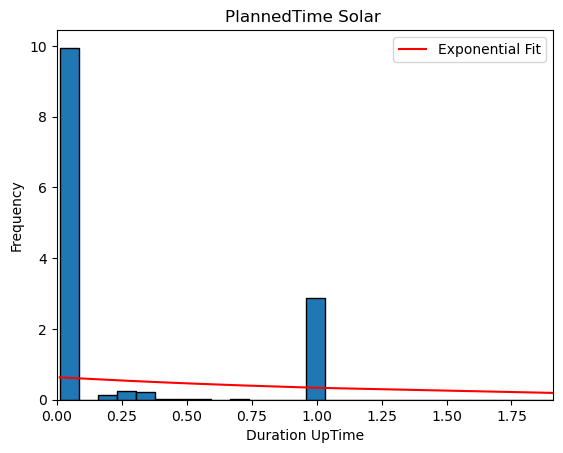

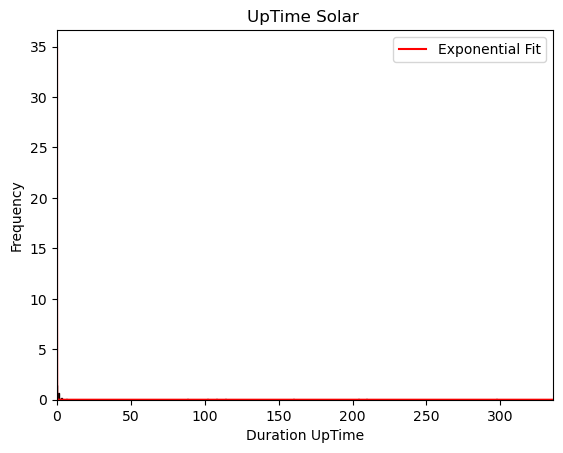

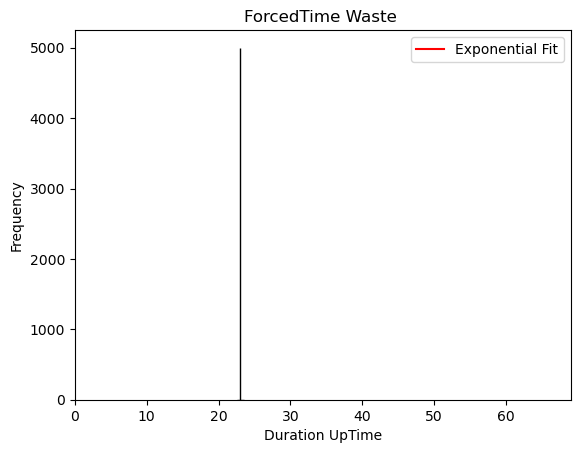

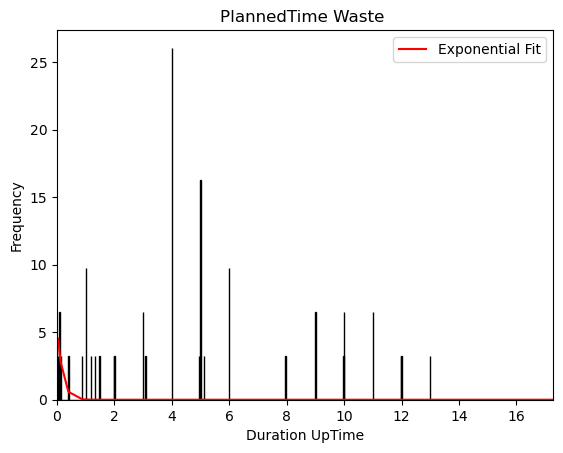

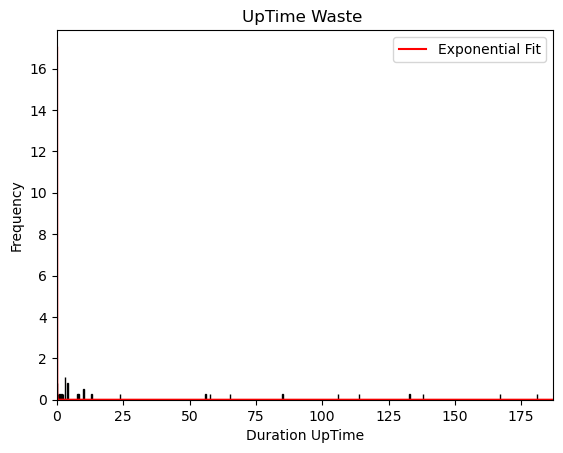

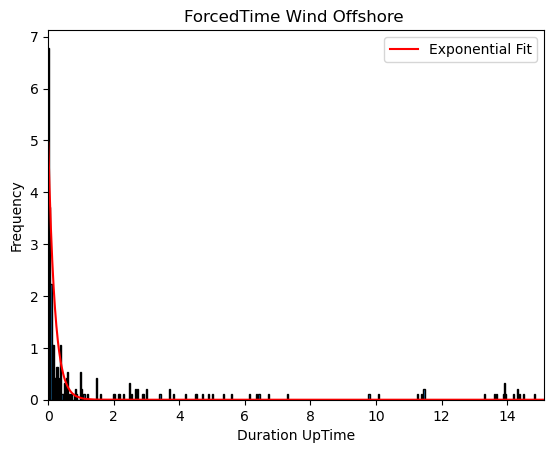

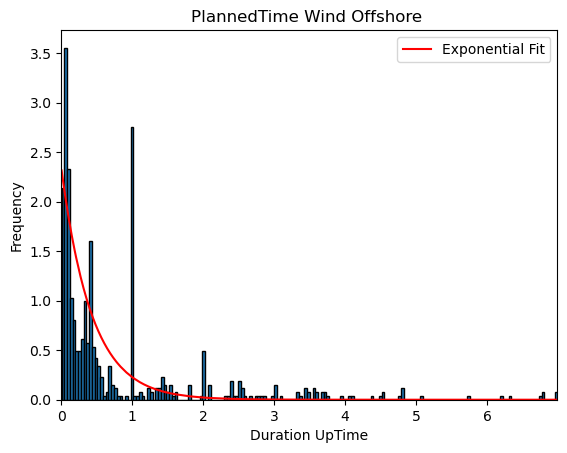

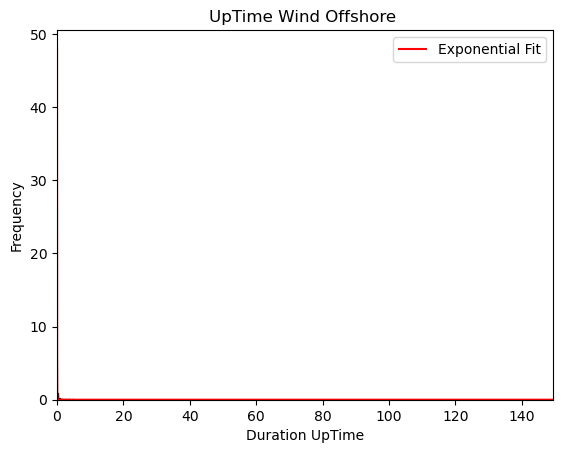

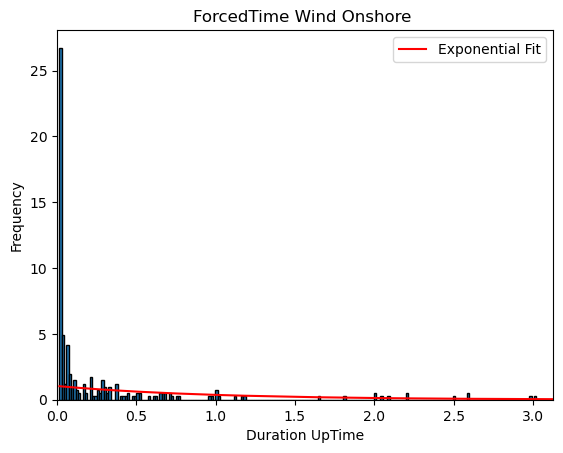

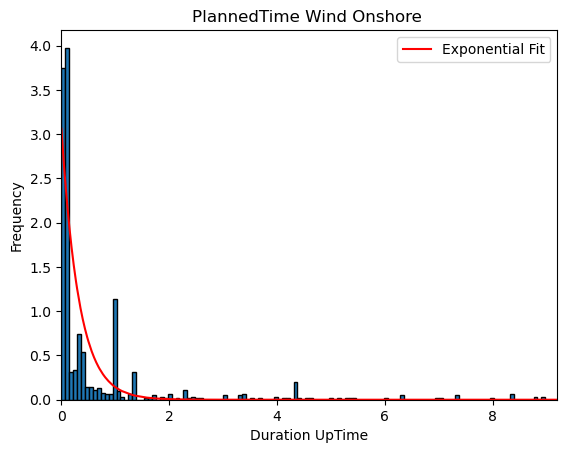

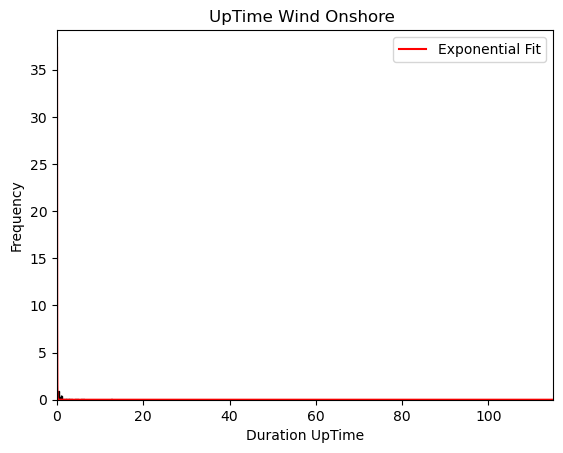

In [111]:

#fit outages distributions
params = pd.DataFrame() #create empty parameter table
grouped_delta = delta_df.groupby(["ProductionType"])
params["ProductionType"] = grouped_delta.first().reset_index()["ProductionType"]
for state in states:
    params[state + "Time"] = [np.nan]*len(list(params["ProductionType"]))


def exponential_fit(x, scale):
    return expon.pdf(x, scale=scale)


for group_name, group_df in grouped_delta:
    
    #We drop NaN valued rows
    #group_df = group_df.dropna(subset = ["UpTime","OffTime"])
    
    for state in states:
        if not pd.isna(group_df[state+"Time"].mean()):
            # Fit the data to the exponential function
            mean = group_df[state+"Time"].mean()
            state_scale = 1/ mean
            params.loc[params["ProductionType"] == group_name, state+"Time"] = state_scale
            plt.figure()
            plt.xlim(0, 3*mean)  # Adjust the values as needed
            #plt.ylim(0, 1)  # Adjust the values as needed
            plt.hist(group_df[state + "Time"], bins=5000, edgecolor='black', density=True)
            # Plot the fitted exponential distribution
            x = np.sort(group_df[state + "Time"])
            plt.plot(x, exponential_fit(x, state_scale), 'r-', label='Exponential Fit')
            plt.xlabel('Duration UpTime')
            plt.ylabel('Frequency')
            plt.title(f'{state}Time {group_name}')
            plt.legend()
            plt.show()


#return

# Markov Chain modeling
In reality we may have more states: 
- On
- Off
- Mai (Maintenance) <br>
We can model the passage from one state to an other as a Homogeneous Markov State:
that is givens a state S1 we model the probability of going to each of the states: On, Off, Mai
and we assume this probability does not depend upon the states before S1.

In this section first we try to understand whether Maintenance has some regularity which may make it easy to predict in the future.
Then, given a set of States we try to model the transition probabilities of the associated Markov Chaint between each pair of states.


### Maintenance modeling
In this section we look at the distribution of the maintenance for each generator.

Conclusion:
There seem to be some regularity in some of the generators but it's not clear to me how we could model it

In [ ]:
maintenance_df = df[df["Reason"] == "Foreseen Maintenance"].sort_values(by = ["UnitName","StartTS"])
#maintenance_df["Delta Maintenance"] = maintenance_df.groupby("UnitName")["StartTS"].diff() 
# time passed from the previous maintenance

for unit, unit_df in maintenance_df.groupby("UnitName"):
    shifted_endts = unit_df["EndTS"][:-1]
    start_ts = unit_df["StartTS"][1:]
    maintenance_df.loc[maintenance_df["UnitName"] == unit, "UpTime"] = np.array(start_ts) - shifted_endts
    
    
maintenance_df = maintenance_df.groupby("UnitName").filter(lambda x: len(x) > 4).reset_index() #take only generators with enough maintenance to see a pattern

k = 0
for unit_name , group_df in maintenance_df.groupby(["UnitName"]):
    unit_type = group_df["ProductionType"].iloc[0]
    plotted_types = []
    if k < 19 and unit_type not in plotted_types:
        
        plotted_types.append(unit_type)
        k = k+1
        plt.figure()  # Create a new figure for each UnitName
        for index, row in group_df.iterrows():
            plt.plot([row['StartTS'], row['StartTS']], [0, 1], color='red', linewidth=2)  # Adjust [0, 1] to set the height of the spike

            
        # Customize the plot
        plt.yticks([])  # Hide y-axis ticks
        plt.xlabel('Date')
        plt.title(f'Maintenance Timeline - {unit_name, unit_type}')
        plt.show()
        
k = 0
for unit_name, group_df in maintenance_df.groupby(["UnitName"]):
    unit_type = group_df["ProductionType"].iloc[0]
    plotted_types = []
    if k < 19 and unit_type not in plotted_types:
        k += 1
        y = group_df["UpTime"] / np.timedelta64(1,"h")
        plt.hist(y, bins = 100)
        plt.xlabel('Hours Between maintenances')
        plt.title(f'Maintenance Histogram - {unit_name, unit_type}')
        plt.show()

## Transition probabilities estimation


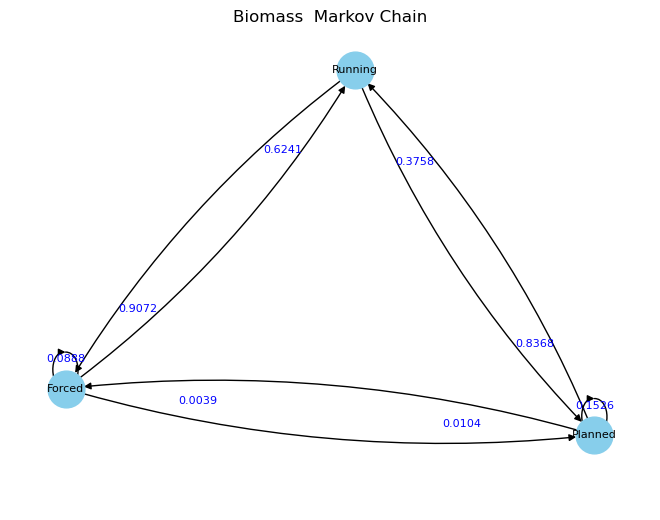

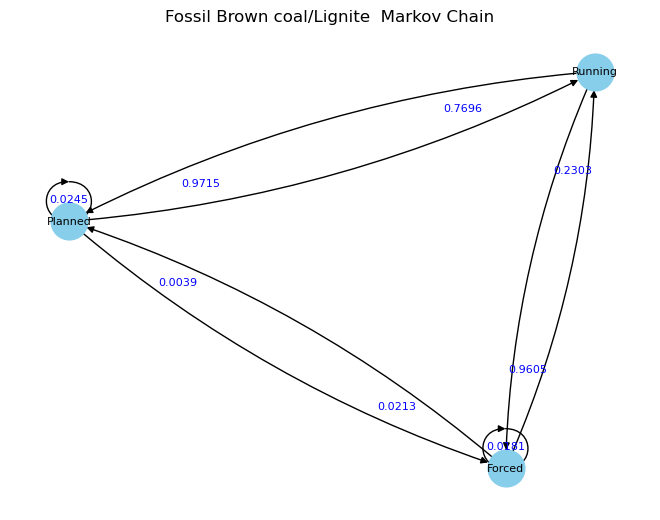

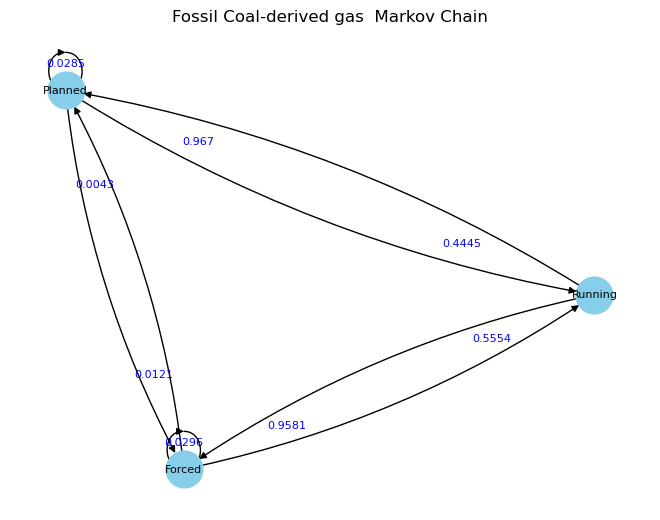

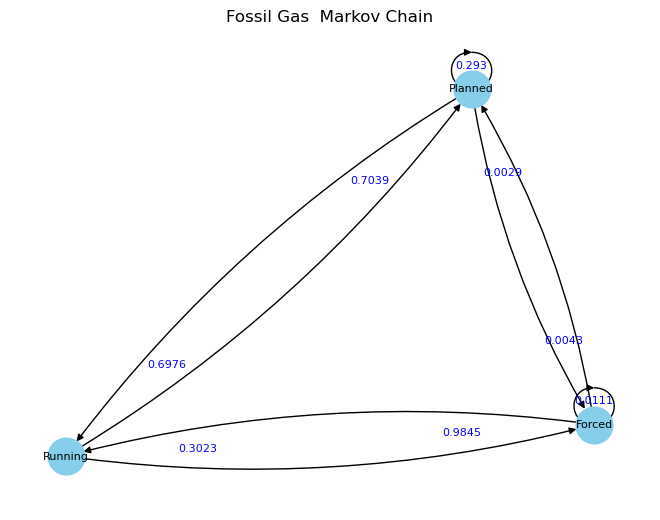

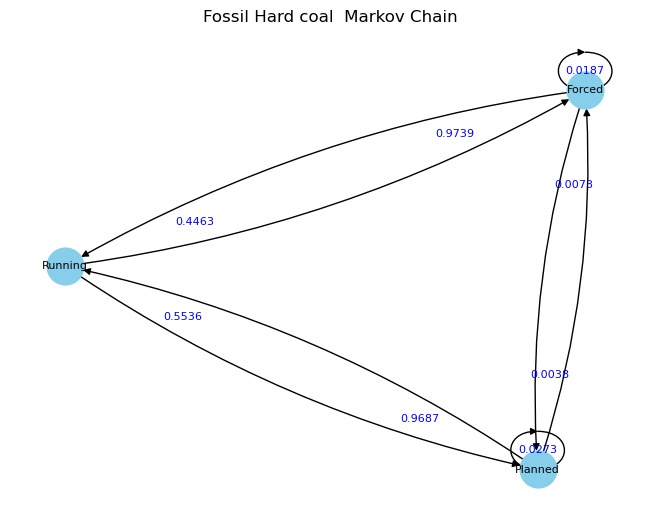

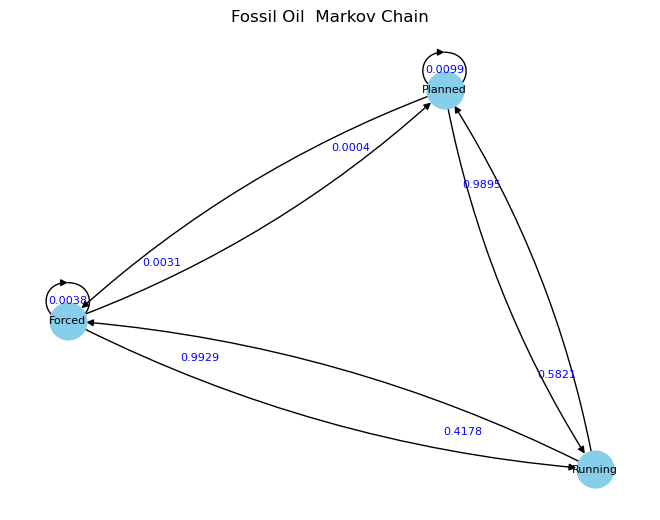

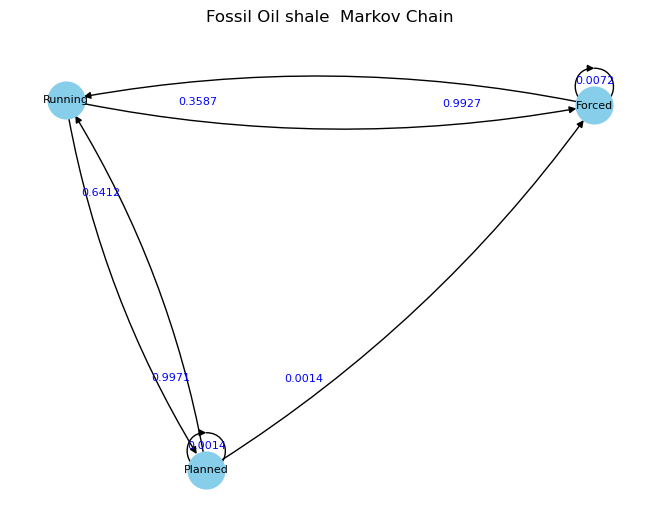

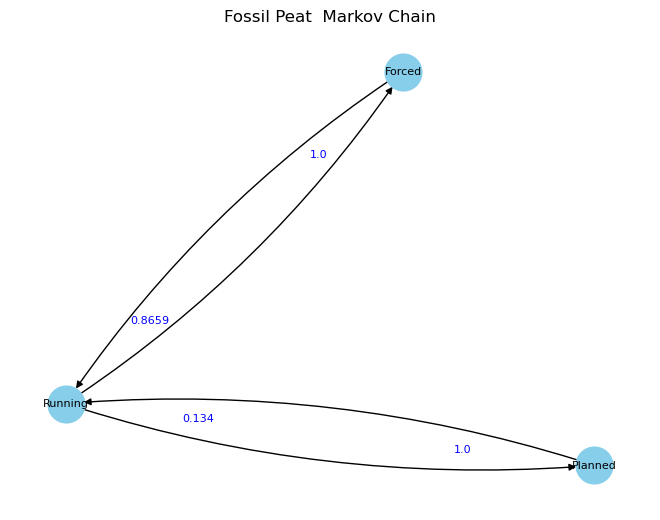

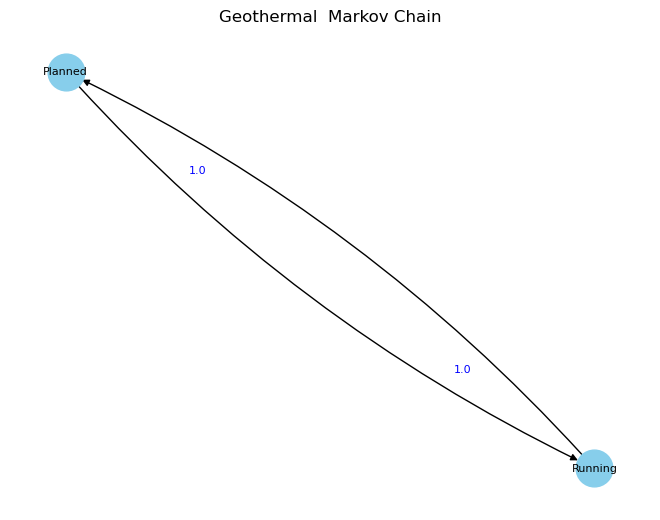

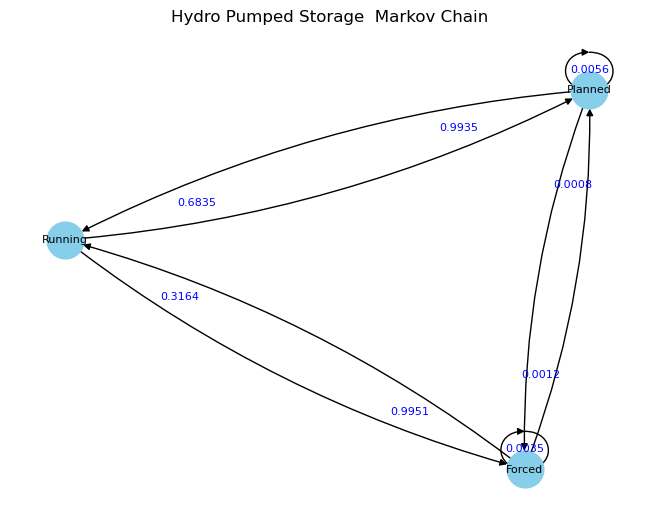

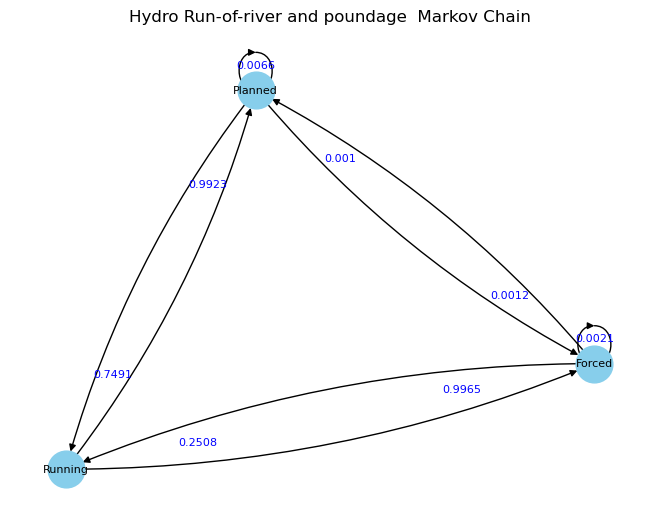

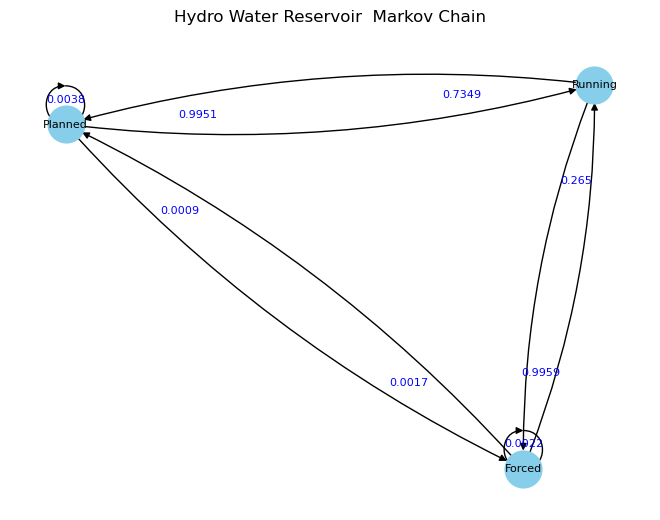

KeyboardInterrupt: 

In [130]:
df = delta_df[delta_df["Reason"] != "Shutdown" ] #remove shutdowns 


#Create a list containing tuples rapresenting all possible state changes (x,y) := x --> y
#data is a dataframe containing the correct "UpTime" between the states considered

GenTypeGroup_df = df.groupby("ProductionType")

#We can use different states
#print markov chain for each type of generator
for production_type, data in GenTypeGroup_df:
    transitions_probs = get_markov_probs(data, "Type")
    markov_graph(transitions_probs, title = f"{production_type} Markov Chain")

#t_probs = dict(transitions_probs)
#for key, value in transitions_probs.items():
#    if value < 0.05:
#        del t_probs[key]
#print graph
    

# Capacity Modeling

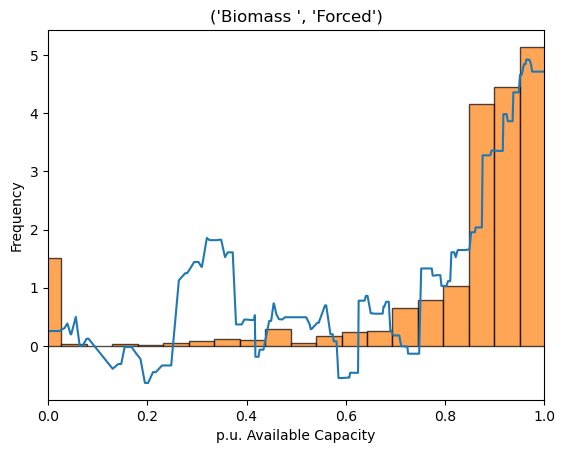

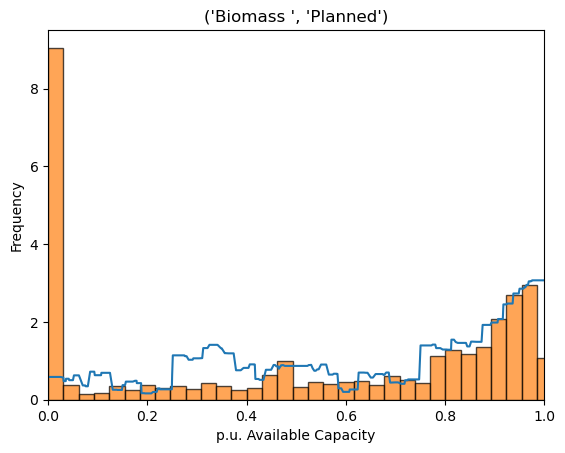

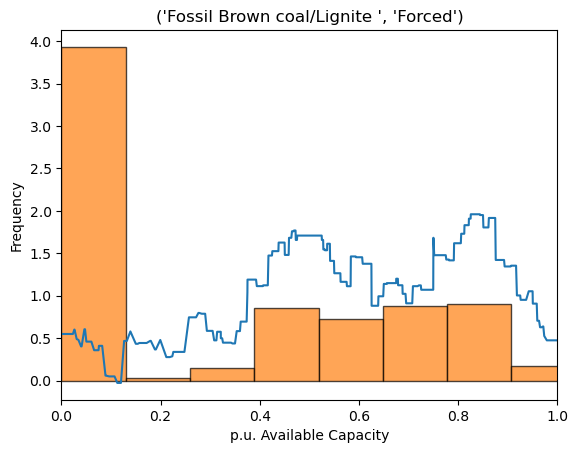

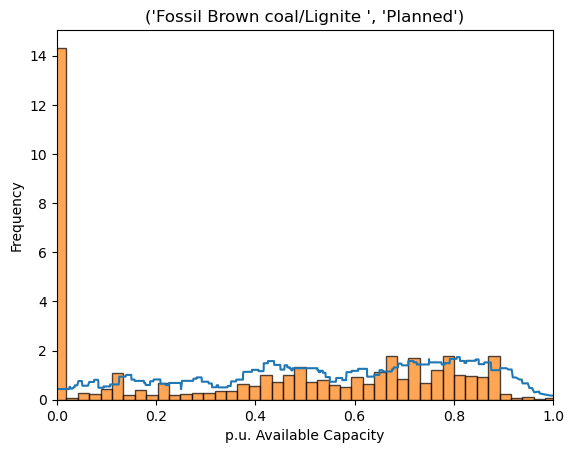

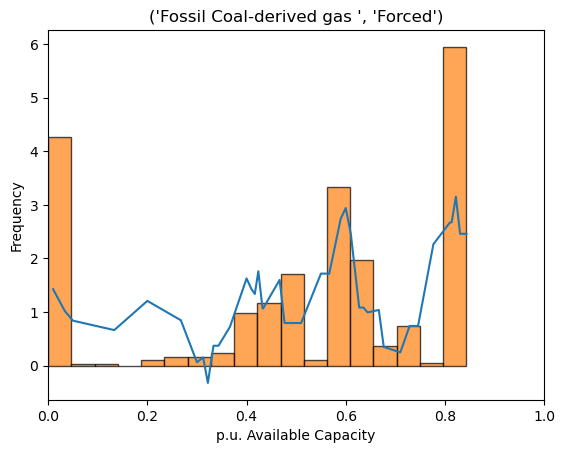

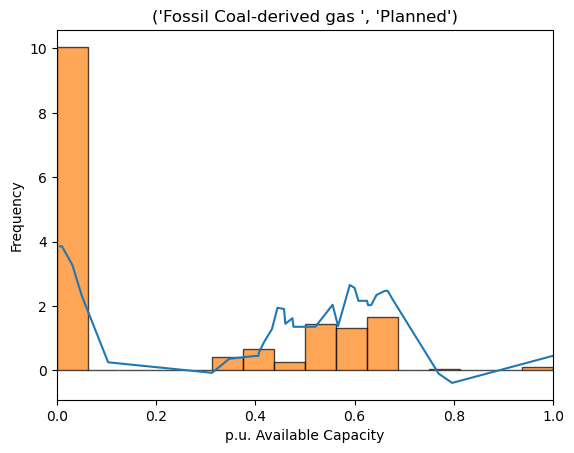

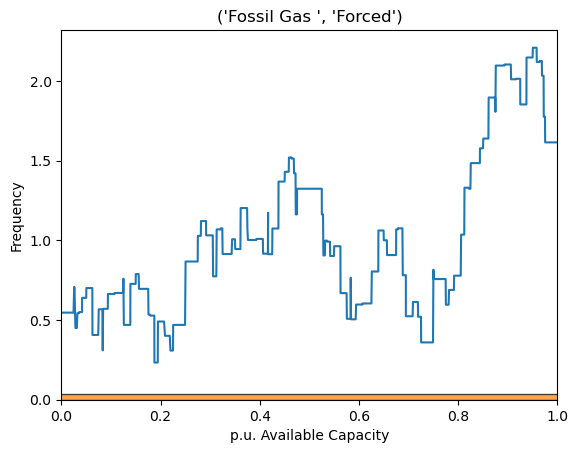

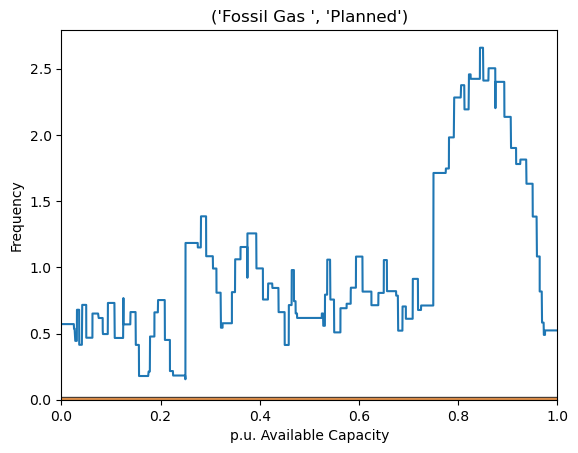

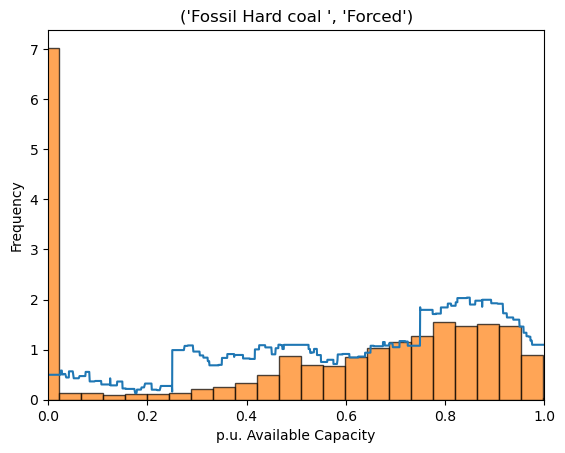

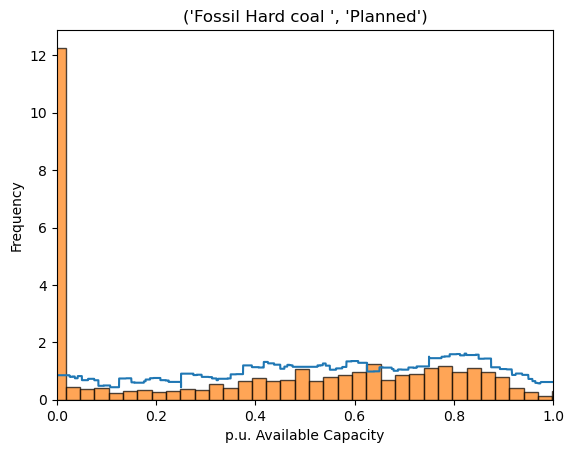

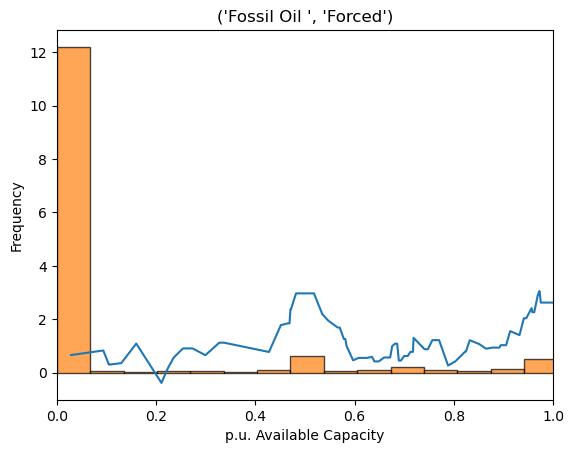

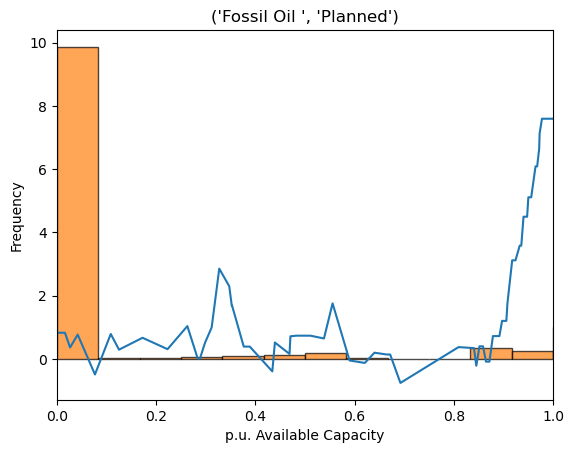

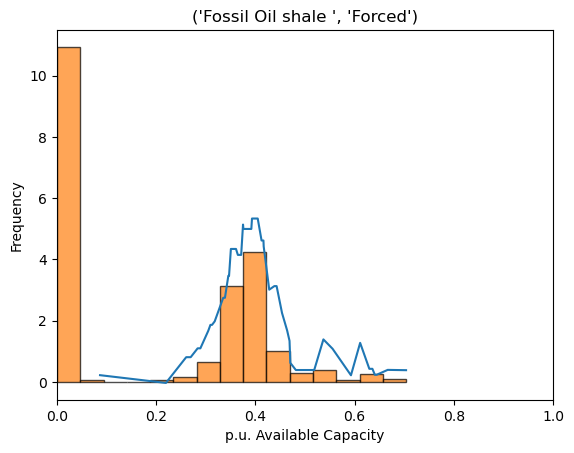

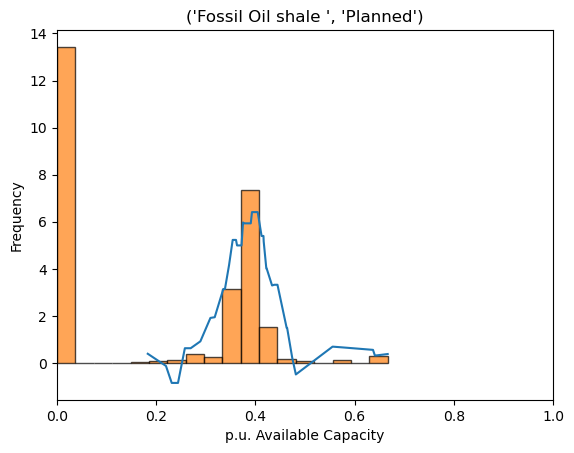

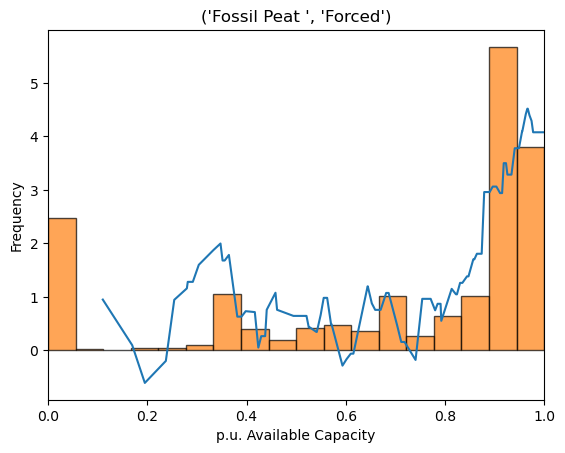

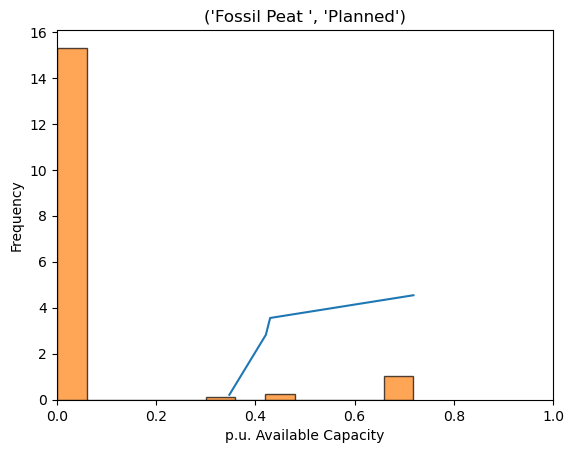

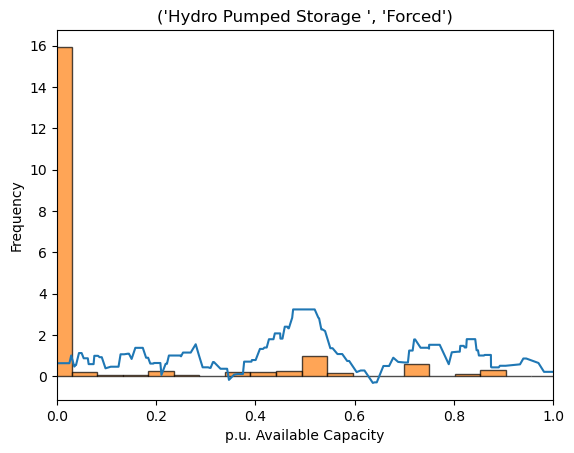

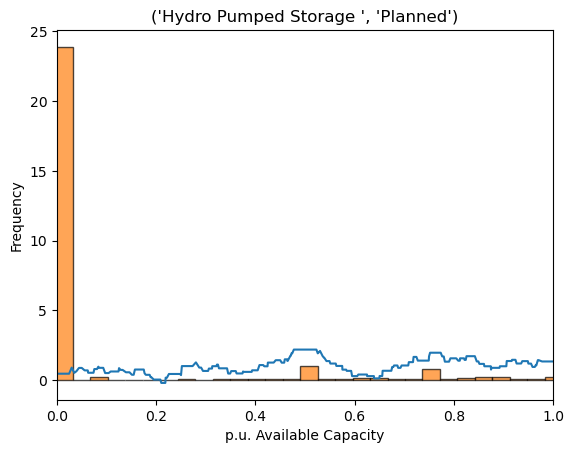

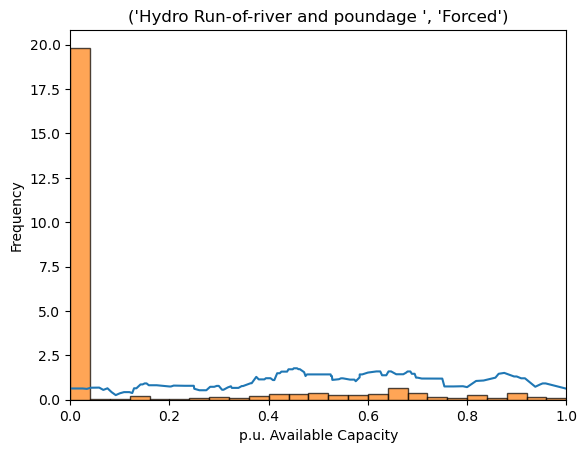

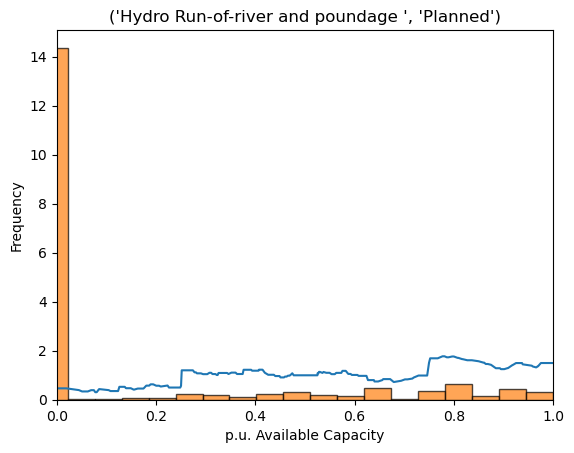

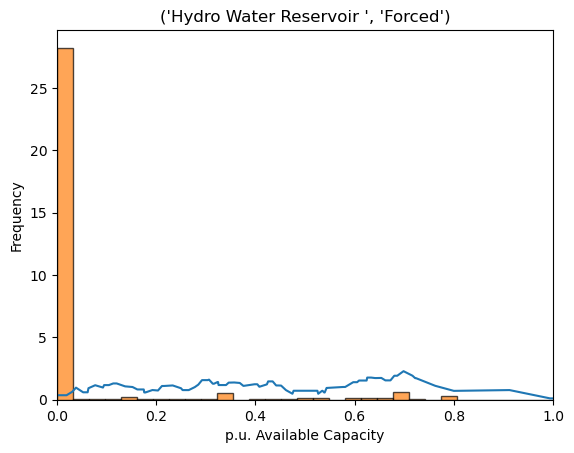

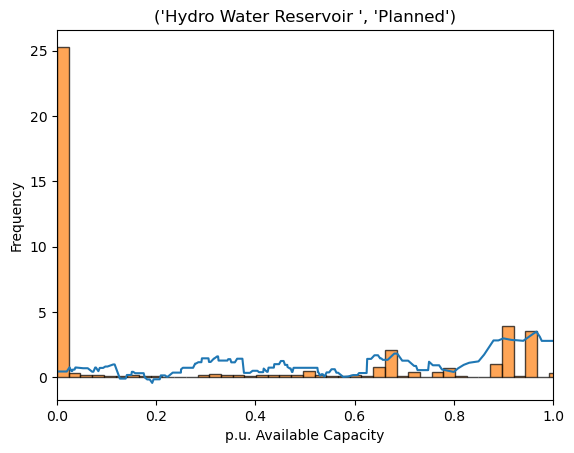

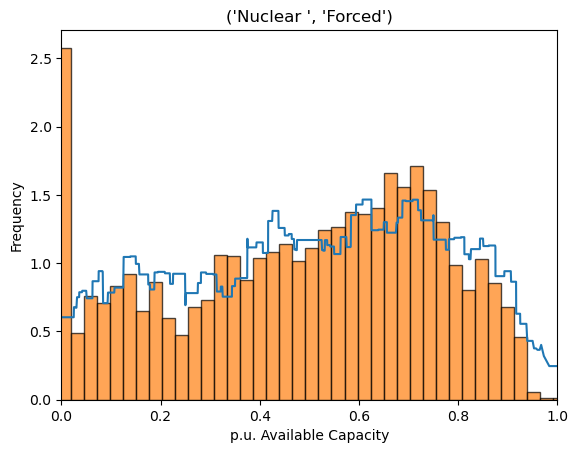

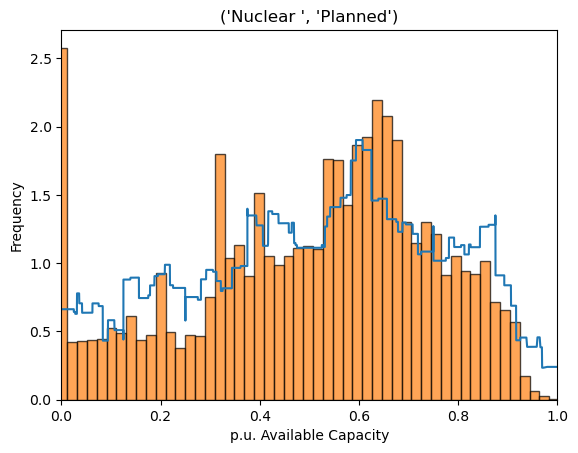

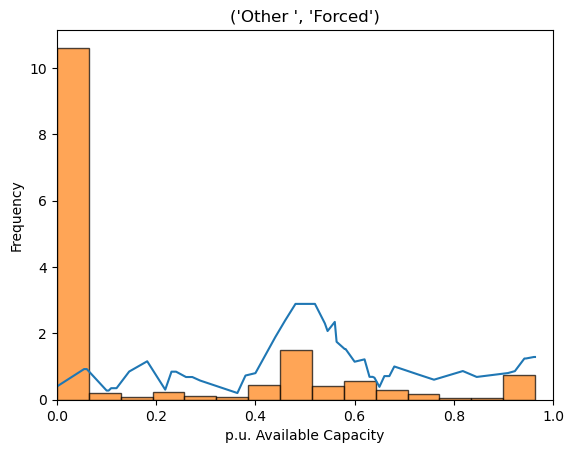

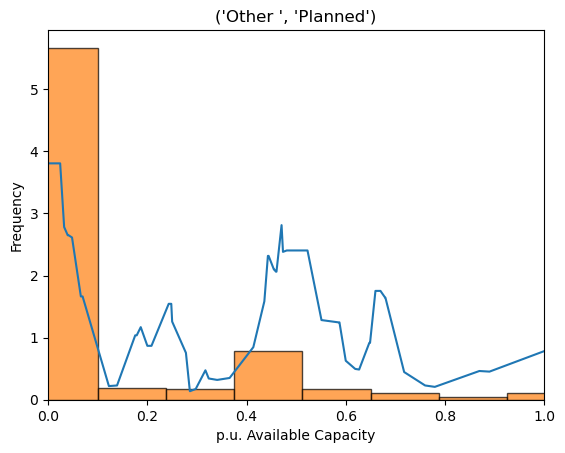

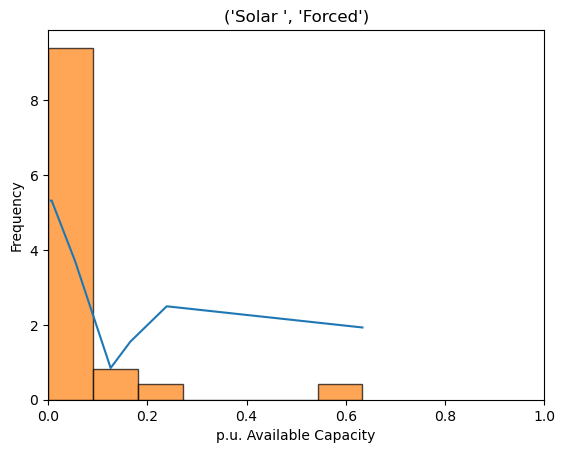

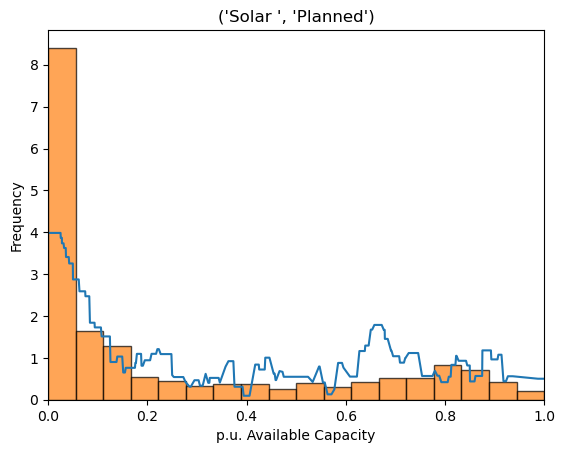

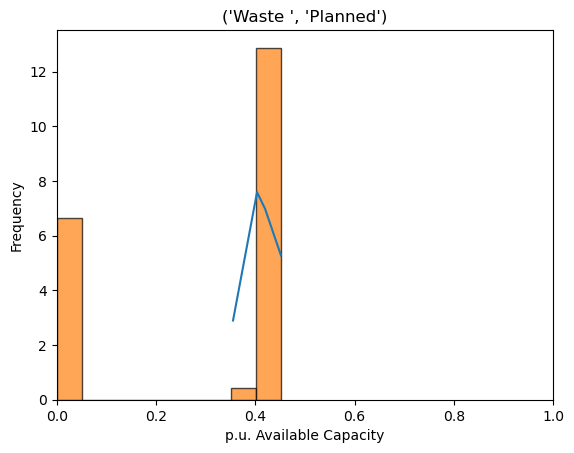

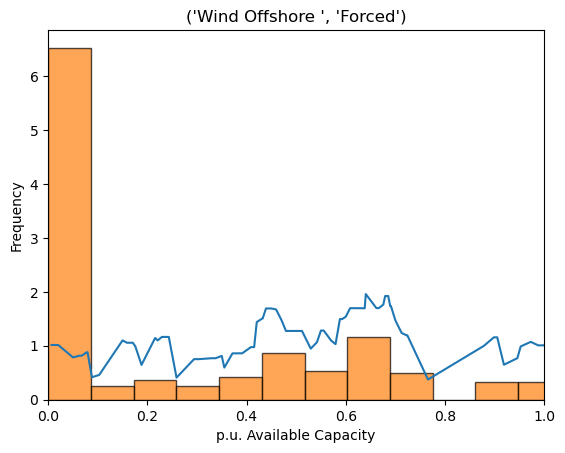

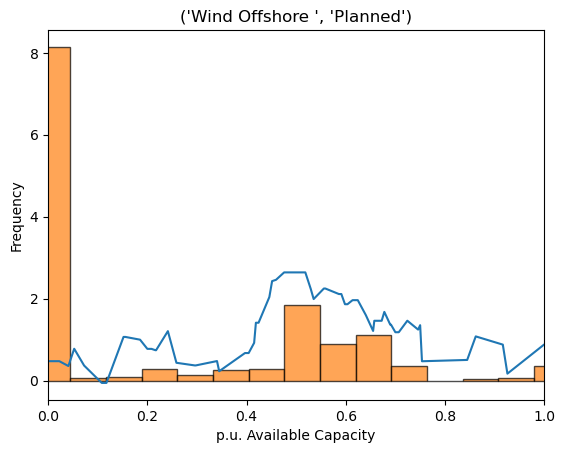

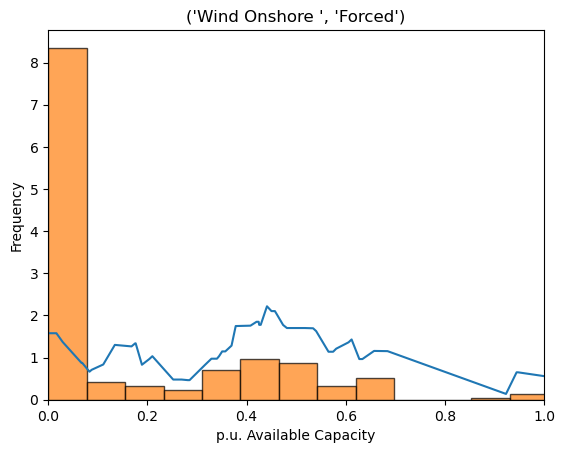

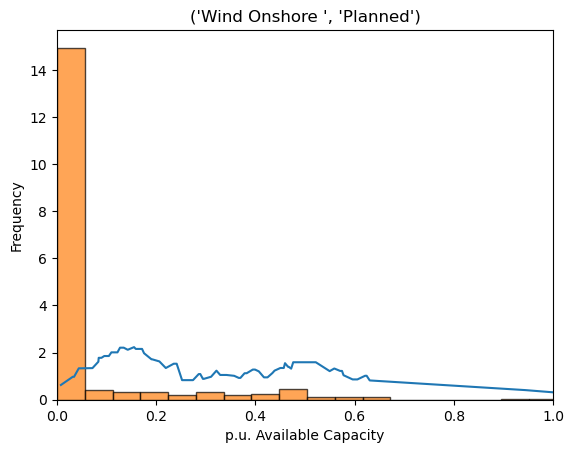

In [50]:
#With Orthogonal Series Decomposiziont ---> meh

grouped_df = df.groupby(["ProductionType", "Type"])
#idea: calculate prob for capacity = 0, remove and the use non parametric fit.
for production_type, prod_df in grouped_df:
    #calculate per unit available capacity
    PU = prod_df["AvailableCapacity"] / prod_df["InstalledCapacity"]
    df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU
    PU = PU[~np.isnan(PU)]
    p_0 = np.sum(PU == 0) / len(PU)
    PUplus = PU[PU != 0] #non zero capacities
    if len(PUplus) != 0:
        a = OrthogonalSeriesEstimator(PUplus, Phi, 10)
        pdf = lambda x: OrthogonalSeriesFun(x, Phi, a)
        vec_pdf = np.vectorize(pdf)
    
         # Plot histogram

        plt.xlim(0, 1)
        plt.plot(np.sort(PUplus), vec_pdf(np.sort(PUplus)))
        plt.hist(PU, bins=min(500, int(np.ceil(len(PU) ** (1. / 3))*3/2)) + 3 , edgecolor='black', alpha=0.7, density = True)

        # Customize the plot (add labels, title, etc.)
        plt.xlabel('p.u. Available Capacity')
        plt.ylabel('Frequency')
        plt.title(f'{production_type}')
        plt.show()

In [42]:
#With Orthogonal Series Decomposiziont ---> meh

grouped_df = df.groupby(["ProductionType", "Type"])
#idea: calculate prob for capacity = 0, remove and the use non parametric fit.
for production_type, prod_df in grouped_df:
    #calculate per unit available capacity
    PU = prod_df["AvailableCapacity"] / prod_df["InstalledCapacity"]
    df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU
    PU = PU[~np.isnan(PU)]
    p_0 = np.sum(PU == 0) / len(PU)
    PUplus = np.sort(PU[PU != 0]) #non zero capacities
    if len(PUplus) != 0:
        
        colors = ["navy", "cornflowerblue", "darkorange"]
        kernels = ["gaussian", "tophat", "epanechnikov"]
        lw = 2
        
        for color, kernels in zip(colors, kernels):
            kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(PUplus)
            log_dens = kde.score_samples(PUplus)
            plt.plot(PUplus, log_dens)
    
        # Plot histogram

        plt.xlim(0, 1)
        
        plt.hist(PU, bins=min(500, int(np.ceil(len(PU) ** (1. / 3))*3/2)) + 3 , edgecolor='black', alpha=0.7, density = True)

        # Customize the plot (add labels, title, etc.)
        plt.xlabel('p.u. Available Capacity')
        plt.ylabel('Frequency')
        plt.title(f'{production_type}')
        plt.show()

701

8689      0.711828
8690      0.898925
8691      0.878495
8693      0.711828
8694      0.878495
            ...   
573169    0.000000
573170    0.000000
573171    0.000000
573172    0.000000
573175    0.000000
Length: 12902, dtype: float64

In [24]:
# discrete prob at 0 + lopsided parametric distribution
int(3.2)

3